# KELOMPOK G

* LEVINA VITA DAMAYANTI (11230940000013)
* ANNISA INTAN NAZILA (11230940000031)
* AGVANIA RIANTI (11230940000037)
* TITI PRAMUDITA WIJAYANTI (11230940000041)

In [ ]:
!pip install PySastrawi
!pip install google-play-scraper
#!pip install gensim
!pip install transformers datasets
!pip install evaluate
!pip install langid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=f445184d6717a189090c103bd45b4f68a45c3087b05ca6c3e7fd196c373a29ad
  Stored in directory: /root/.cache/pip/wheels/3c/bc/9d/266e27289b9019680d65d9b608c37bff1eff565b001c977ec5
Successfully built langid


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google_play_scraper import app
from google_play_scraper import Sort, reviews_all
import evaluate
from transformers import BertTokenizer, TFBertForSequenceClassification, TrainingArguments, Trainer, set_seed
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from datasets import Dataset
#from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import random
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

SEED = 4
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
set_seed(SEED)

import nltk
import re
from PIL import Image
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
import langid

nltk.download('punkt_tab')
nltk.download('stopwords') # Added this line to download missing stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory_sw = StopWordRemoverFactory()
stopwords_indo = factory_sw.get_stop_words()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopwords_indo

['a',
 'ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'arti',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'b',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagainamakah',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasannya',
 'bahwasanya',
 'baik',
 'baiklah',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'bera

## Scraping

In [ ]:
def scrape_review(lang='id', id_link=id):
  reviews = reviews_all(id_link,sleep_milliseconds=0, # defaults to 0
                      #lang=lang, country='id', # bisa dihilangkan atau dipake
                      sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
                      )

  df = pd.DataFrame(np.array(reviews),columns=['review'])
  df = df.join(pd.DataFrame(df.pop('review').tolist()))
  return df

In [ ]:
def preprocessing(kalimat, stopwords = stopwords_indo):
  hasil = []

  #list stop words, bisa ditambahkan sesuai kebutuhan
  kalimat = str(kalimat).translate(str.maketrans("","",string.punctuation))  # hapus tanda baca
  kalimat = re.sub(r"\d+", "", kalimat)                                      # hapus angka
  norm = kalimat.lower()                                                     # jadikan huruf kecil
  stem = stemmer.stem(norm)                                                  # stemming
  list_token = nltk.word_tokenize(stem)                                      # tokenisasi

  for i in list_token:
    if i not in stopwords:
      hasil.append(i)                                                       # hapus stop words
  return hasil

In [ ]:
def text_preprocessing(text):
    text = str(text).lower() # Convert to string and lowercase
    text = re.sub(r"\d+", "", text) # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation)) # remove punctuation
    text = ' '.join([word for word in str(text).split() if word not in stopwords_indo]) # remove stopwords
    text = stemmer.stem(text) # stemming
    return text

Fungsi untuk Medendeteksi bahasa

In [ ]:
def detect_lang(text):
    try:
        lang, prob = langid.classify(text)
        return lang
    except:
        return "unknown"


# Disney+

In [ ]:
# Mengambil ID aplikasi dari Play Store
id1 ='in.startv.hotstar.dplus' #isi id disini
disneyplus = scrape_review(lang='id', id_link=id1)
disneyplus

reviewId       userName  \
0      ce215a85-5ad4-4c0b-a41f-9fe69d48d4dc  A Google user   
1      f1e7c5db-7593-4fac-a53e-ada0084d701e  A Google user   
2      7fc1c042-5c9f-4e84-9314-3b27fb0b070a  A Google user   
3      ee5cc580-83bb-4d8d-a241-c8a6e4fee0cf  A Google user   
4      58ebbde4-f361-46c2-9b13-f91075207ae6  A Google user   
...                                     ...            ...   
13481  91a589a1-8d02-4fed-bccb-63a07189aa9b  A Google user   
13482  cb6ae20b-1acd-4835-aff9-c95735cd80d7  A Google user   
13483  d63bc1ea-a44a-4573-8ca1-b4c4f7d11e6a  A Google user   
13484  e4d9722e-eabf-439f-85d3-9d12df060b6d  A Google user   
13485  4a5c1e25-e5a8-49a8-aabd-31a4d4231ada  A Google user   

                                               userImage  \
0      https://play-lh.googleusercontent.com/EGemoI2N...   
1      https://play-lh.googleusercontent.com/EGemoI2N...   
2      https://play-lh.googleusercontent.com/EGemoI2N...   
3      https://play-lh.googleusercontent.com/EGemoI2N...   
4      https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
13481  https://play-lh.googleusercontent.com/EGemoI2N...   
13482  https://play-lh.googleusercontent.com/EGemoI2N...   
13483  https://play-lh.googleusercontent.com/EGemoI2N...   
13484  https://play-lh.googleusercontent.com/EGemoI2N...   
13485  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
0            I PAID FOR THIS APP AND IT JUST BLACK OUTTT      1   
1                                          susah Login..      1   
2      worst app! most unfriendly user interface app!...      1   
3      I'm uninstalling this app because what the f i...      5   
4      its very poor..monthly auto debit but same mov...      2   
...                                                  ...    ...   
13481                               Second downloader! 😝      5   
13482                                       Nice, indeed      5   
13483            Baru download, akunnya baru aktif besok      5   
13484                              Thank you! i love it!      5   
13485                                  First downloader!      5   

       thumbsUpCount reviewCreatedVersion                  at  \
0                  0                 None 2025-12-29 13:53:39   
1                  0           25.12.08.1 2025-12-29 13:27:37   
2                  0                 None 2025-12-29 11:00:39   
3                  0                 None 2025-12-29 04:44:43   
4                  0           25.12.08.1 2025-12-29 04:05:24   
...              ...                  ...                 ...   
13481              1               11.0.2 2020-09-04 13:12:19   
13482              0               11.0.2 2020-09-04 13:10:51   
13483              8               11.0.2 2020-09-04 13:09:34   
13484              1               11.0.2 2020-09-04 12:52:07   
13485              1               11.0.2 2020-09-04 12:44:23   

                                            replyContent           repliedAt  \
0      Hai Fredie, mohon maaf atas ketidaknyamanannya... 2025-12-30 07:33:07   
1      Hai! Mohon maaf atas ketidaknyamannya. Mohon k... 2025-12-30 07:29:27   
2      Hi Aylina, we apologize for the inconvenience ... 2025-12-30 08:09:03   
3                                                   None                 NaT   
4                                                   None                 NaT   
...                                                  ...                 ...   
13481                                               None                 NaT   
13482                                               None                 NaT   
13483                                               None                 NaT   
13484                                               None                 NaT   
13485                                               None                 NaT   

       appVersion  
0 

In [ ]:
disneyplus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13486 entries, 0 to 13485
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              13486 non-null  object        
 1   userName              13486 non-null  object        
 2   userImage             13486 non-null  object        
 3   content               13486 non-null  object        
 4   score                 13486 non-null  int64         
 5   thumbsUpCount         13486 non-null  int64         
 6   reviewCreatedVersion  10790 non-null  object        
 7   at                    13486 non-null  datetime64[ns]
 8   replyContent          2889 non-null   object        
 9   repliedAt             2889 non-null   datetime64[ns]
 10  appVersion            10790 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.1+ MB


In [ ]:
# deteksi bahasa langsung pada dataframe dari Play Store
disneyplus["lang"] = disneyplus["content"].astype(str).apply(detect_lang)

# filter hanya Indonesia
disneyplus = disneyplus[disneyplus["lang"] == "id"]

disneyplus

reviewId       userName  \
1      f1e7c5db-7593-4fac-a53e-ada0084d701e  A Google user   
20     ad79585c-6061-4e96-8e05-f4eff39bca32  A Google user   
23     0da31945-333e-42bc-ac2a-6f5de94f995a  A Google user   
34     cea61bd7-c26d-4efc-8cfe-9ef570308fb9  A Google user   
40     669309bd-3be3-4bf0-b070-0ec08bc99e97  A Google user   
...                                     ...            ...   
13462  ba6051c6-cb89-4820-9598-61113d6f3321  A Google user   
13464  e046411a-7ee7-47a1-a40b-510969f68202  A Google user   
13467  a4009776-7be1-499e-988f-bb69b435932a  A Google user   
13472  476f9430-7544-42ab-b9d6-2f66cbfec886  A Google user   
13479  4bb90ef2-359e-46b2-a9c8-147a9b6e2e2b  A Google user   

                                               userImage  \
1      https://play-lh.googleusercontent.com/EGemoI2N...   
20     https://play-lh.googleusercontent.com/EGemoI2N...   
23     https://play-lh.googleusercontent.com/EGemoI2N...   
34     https://play-lh.googleusercontent.com/EGemoI2N...   
40     https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
13462  https://play-lh.googleusercontent.com/EGemoI2N...   
13464  https://play-lh.googleusercontent.com/EGemoI2N...   
13467  https://play-lh.googleusercontent.com/EGemoI2N...   
13472  https://play-lh.googleusercontent.com/EGemoI2N...   
13479  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
1                                          susah Login..      1   
20     hampir semua film buffering, hanya muncul laya...      1   
23     gak bisa log in padahal udah seminggu, tapi be...      1   
34         setiap memasukkan no ponsel selalu bermasalah      2   
40     sudah kirim email tidak ada solusi. nonton sam...      1   
...                                                  ...    ...   
13462  YES!, Yang ditunggu" akhirnya bisa nonton Marv...      5   
13464  Saya ga dapat 4 kode untuk subscribe. Sudah be...      2   
13467  App nya belum sempurna. Ga bisa di cast ke tv,...      2   
13472  App sudah saya install di android tv tp tampil...      3   
13479  Mudah2an masih bakal di update. Sekarang kadan...      3   

       thumbsUpCount reviewCreatedVersion                  at  \
1                  0           25.12.08.1 2025-12-29 13:27:37   
20                 0                 None 2025-12-22 22:35:16   
23                 0           25.12.08.1 2025-12-22 12:47:48   
34                 0           25.11.24.2 2025-12-21 12:19:49   
40                 2           25.11.24.2 2025-12-21 06:32:36   
...              ...                  ...                 ...   
13462              0               11.0.2 2020-09-04 15:45:09   
13464              1               11.0.2 2020-09-04 15:30:05   
13467              2               11.0.2 2020-09-04 15:20:18   
13472              0               11.0.2 2020-09-04 14:46:38   
13479             24               11.0.2 2020-09-04 13:15:09   

                                            replyContent           repliedAt  \
1      Hai! Mohon maaf atas ketidaknyamannya. Mohon k... 2025-12-30 07:29:27   
20     Hai, mohon maaf atas ketidaknyamanannya. Kamu ... 2025-12-24 08:40:54   
23                                                  None                 NaT   
34     Hai, mohon maaf atas ketidaknyamanannya. Kamu ... 2025-12-23 09:30:16   
40     Hai Yoana, mohon maaf atas ketidaknyamanannya.... 2025-12-16 07:18:38   
...                                                  ...                 ...   
13462                                               None                 NaT   
13464                                               None                 NaT   
13467  Hai! Sekarang kamu bisa nonton di layar yang l... 2020-09-13 05:01:44   
13472                                               None                 NaT   
13479                                               None                 NaT   

       appVersion lang

In [ ]:
columns_to_drop = ['reviewCreatedVersion','replyContent','repliedAt','userImage']
existing_columns = [col for col in columns_to_drop if col in disneyplus.columns]
disneyplus = disneyplus.drop(columns=existing_columns, axis=1)
disneyplus

reviewId       userName  \
1      f1e7c5db-7593-4fac-a53e-ada0084d701e  A Google user   
20     ad79585c-6061-4e96-8e05-f4eff39bca32  A Google user   
23     0da31945-333e-42bc-ac2a-6f5de94f995a  A Google user   
34     cea61bd7-c26d-4efc-8cfe-9ef570308fb9  A Google user   
40     669309bd-3be3-4bf0-b070-0ec08bc99e97  A Google user   
...                                     ...            ...   
13462  ba6051c6-cb89-4820-9598-61113d6f3321  A Google user   
13464  e046411a-7ee7-47a1-a40b-510969f68202  A Google user   
13467  a4009776-7be1-499e-988f-bb69b435932a  A Google user   
13472  476f9430-7544-42ab-b9d6-2f66cbfec886  A Google user   
13479  4bb90ef2-359e-46b2-a9c8-147a9b6e2e2b  A Google user   

                                                 content  score  \
1                                          susah Login..      1   
20     hampir semua film buffering, hanya muncul laya...      1   
23     gak bisa log in padahal udah seminggu, tapi be...      1   
34         setiap memasukkan no ponsel selalu bermasalah      2   
40     sudah kirim email tidak ada solusi. nonton sam...      1   
...                                                  ...    ...   
13462  YES!, Yang ditunggu" akhirnya bisa nonton Marv...      5   
13464  Saya ga dapat 4 kode untuk subscribe. Sudah be...      2   
13467  App nya belum sempurna. Ga bisa di cast ke tv,...      2   
13472  App sudah saya install di android tv tp tampil...      3   
13479  Mudah2an masih bakal di update. Sekarang kadan...      3   

       thumbsUpCount                  at  appVersion lang  
1                  0 2025-12-29 13:27:37  25.12.08.1   id  
20                 0 2025-12-22 22:35:16        None   id  
23                 0 2025-12-22 12:47:48  25.12.08.1   id  
34                 0 2025-12-21 12:19:49  25.11.24.2   id  
40                 2 2025-12-21 06:32:36  25.11.24.2   id  
...              ...                 ...         ...  ...  
13462              0 2020-09-04 15:45:09      11.0.2   id  
13464              1 2020-09-04 15:30:05      11.0.2   id  
13467              2 2020-09-04 15:20:18      11.0.2   id  
13472              0 2020-09-04 14:46:38      11.0.2   id  
13479             24 2020-09-04 13:15:09      11.0.2   id  

[1855 rows x 8 columns]

In [ ]:
disneyplus.isnull().sum()

reviewId           0
userName           0
content            0
score              0
thumbsUpCount      0
at                 0
appVersion       309
lang               0
dtype: int64

In [ ]:
disneyplus["appVersion"] = disneyplus["appVersion"].fillna(
    disneyplus
    .groupby(disneyplus["at"].dt.month)["appVersion"]
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

disneyplus.isnull().sum()

reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
appVersion       0
lang             0
dtype: int64

In [ ]:
# Jumlah Rating Aplikasi
disneyplus['score'].value_counts()

score
1    982
5    320
2    223
3    199
4    131
Name: count, dtype: int64

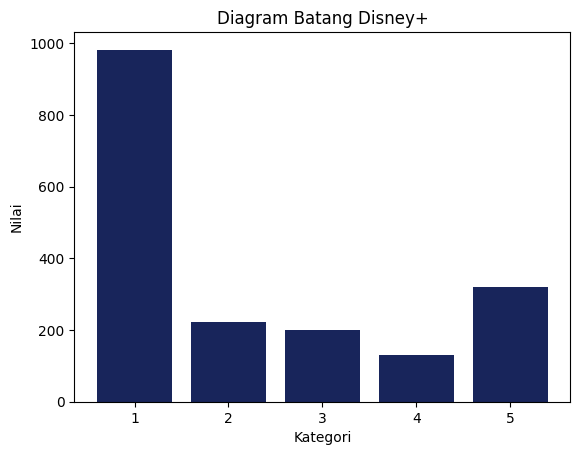

In [ ]:
# Diagram Batang Aplikasi
score_disney = disneyplus['score'].value_counts().sort_index()

# Membuat diagram batang dengan warna Disney+
plt.bar(score_disney.index, score_disney.values, color="#18255b")

# Judul dan label
plt.title("Diagram Batang Disney+")
plt.xlabel("Kategori")
plt.ylabel("Nilai")

# Tampilkan grafik
plt.show()


In [ ]:
# Rata-rata Rating Per Tahun
waktu_disney = disneyplus['score'].groupby(disneyplus['at'].dt.year).mean()
waktu_disney

at
2020    2.845070
2021    2.499033
2022    2.138743
2023    1.914373
2024    1.474453
2025    1.474453
Name: score, dtype: float64

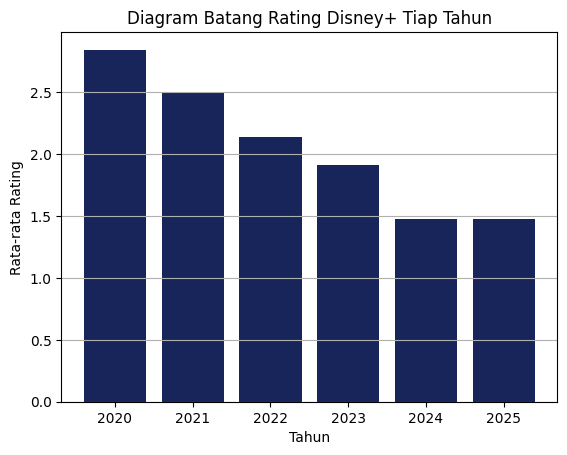

In [ ]:
# Visualisasi Rating apps setiap tahun
score_disney_1 = disneyplus['score'].groupby(disneyplus['at'].dt.year).mean()

# Membuat diagram batang (warna Disney+)
plt.bar(score_disney_1.index, score_disney_1.values, color="#18255b")

# Judul dan label
plt.title("Diagram Batang Rating Disney+ Tiap Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Rating")

# Tampilkan grid
plt.grid(axis='y')
plt.show()


## Analisis Rating 1 dan 5 dari Aplikasi Disney+

In [ ]:
disneyplus1 = disneyplus[disneyplus["score"] == 1].copy()
disneyplus5 = disneyplus[disneyplus["score"] == 5].copy()

### Rating 1 Disney+

In [ ]:
clean = []
kosong = []
for j, i in enumerate(disneyplus1['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

disneyplus1['clean content'] = clean
kosong

[385]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']   #list stop words bisa ditambahkan sendiri
stopwords_indo.extend(tambahan)

konten_clean_disneyplus1 = ""

for index, row in disneyplus1.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_disneyplus1 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_disneyplus1

'susah login film buffering muncul layar hitam indikator strip biru putar selesai log in udah minggu apaapa email pusat bantu slow respon kecewa kirim email solusi nonton pakai data saver tetep buffering kirim email bolak solusi nol cs copy paste bukti vidio udah kirim kasi review udh ganti minus sistem jual uda subscribe login apps refund sumpah trafficnya nyebelin subscribe via telkomsel login delete data delete cache restart nggak login hubung via email solusi gimana siasia subscribe jelek banget aplikasi login gabisa login alas internet internetnya aman aja emg aplikasi aja kocak layan akses provider starlite app disney deteksi lokasi siangapura akses yogyakarta layan detektor ip lokasi indonesia android samsung tv bisasamsung qled trus ngapain subscribe bayar nga tonton error buang uang susah nak register benda apps ni signup tuh gimana apk suruh login pake nomor database suruh masukin email klik email apk masukin nomor gitu aja tuh emang akun signup pilihannyaaaaaaaaa susah login

In [ ]:
clean = []
kosong = []

for j, row in disneyplus1.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
disneyplus1['clean content'] = clean

print(kosong)

[4373]


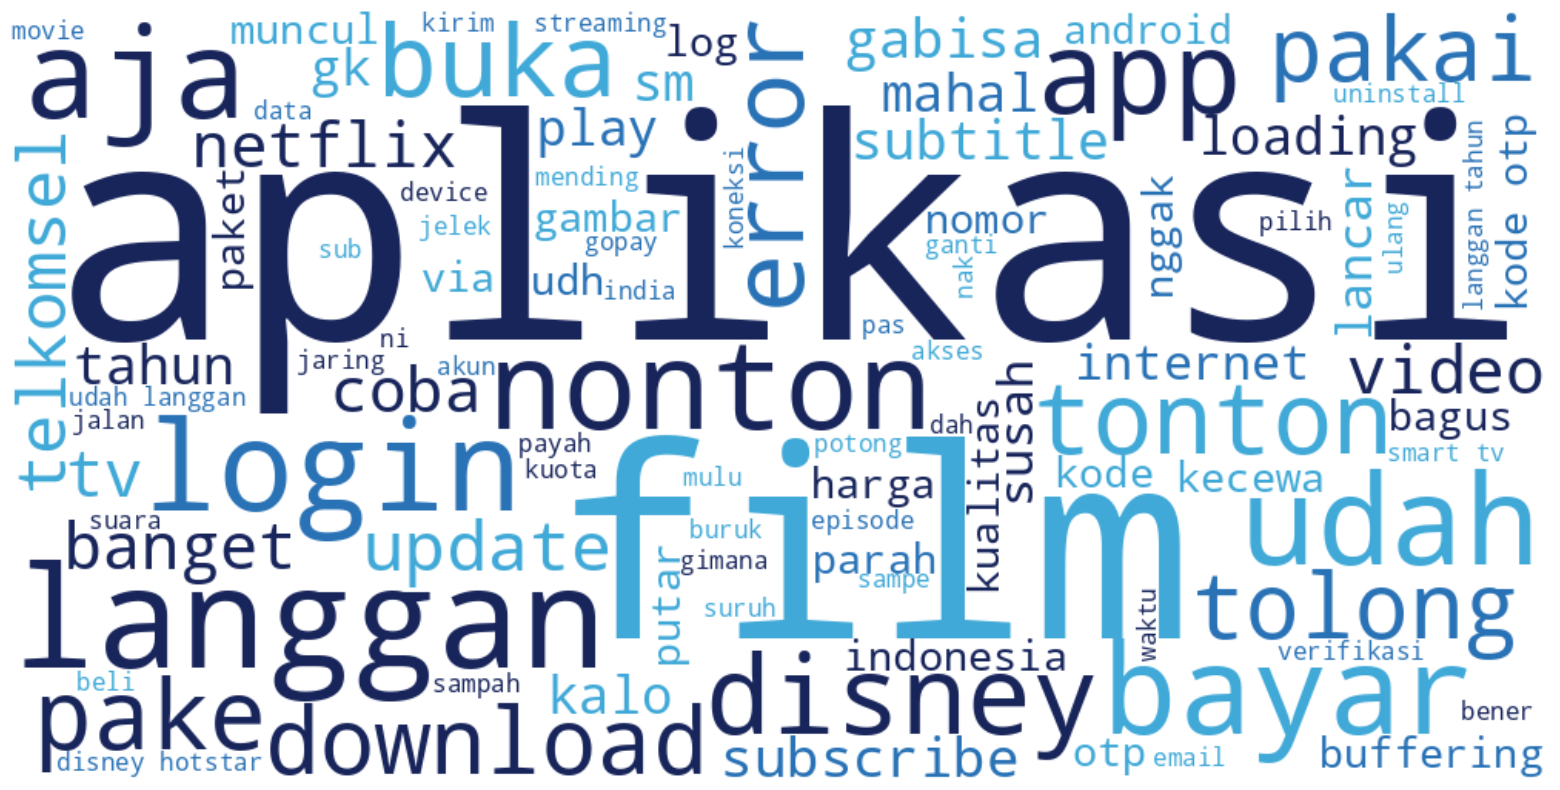

In [ ]:
# Palet warna Disney+
disney_colors = ["#18255b", "#40a9d7", "#2972b6"]
def disney_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(disney_colors)
wordcloud_disney1 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=disney_color_func).generate(konten_clean_disneyplus1)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_disney1, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_disneyplus1.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari disneyplus1
texts_disney1 = disneyplus1['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_disney1 = CountVectorizer(ngram_range=(3,3))
x_disney1 = vectorizer_disney1.fit_transform(texts_disney1)

# mengambil daftar trigram + count
trigram_disney1 = vectorizer_disney1.get_feature_names_out()
trigram_counts_disney1 = x_disney1.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_disneyplus1 = pd.DataFrame({
    'Trigram': trigram_disney1,
    'Count': trigram_counts_disney1
})

# urutkan 50 trigram paling sering muncul
trigram_freq_disneyplus1 = trigram_freq_disneyplus1.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_disneyplus1)

Trigram  Count
6189         something went wrong      7
3511               kode otp kirim      6
7210           udah langgan tahun      5
3517                 kode otp sms      4
2311           film udah download      3
3530          kode verifikasi sms      3
3532        kode verifikasi susah      3
4079               login kode otp      3
4040                  log in udah      3
6135             smart tv samsung      3
5222            pake kartu kredit      3
5831            rugi udah langgan      3
6                 abis update app      3
5721               redmi note pro      2
3510                  kode otp gk      2
4912            nonton udah bayar      2
71               aja jelek banget      2
5628  provider internet telkomsel      2
3809       langgan pake telkomsel      2
3240              kagak buka nihh      2
2392               full hd update      2
4037                  log in pake      2
4504           muncul video suara      2
1576               dapet kode otp      2
7325      uninstall install ulang      2
4490           muncul layar hitam      2
3750         langgan cuman nonton      2
2343       fitur screen mirroring      2
3308           kartu kredit debit      2
5211             pake android box      2
4478              mulu pas nonton      2
3465              kirim udah coba      2
894              bayar pake gopay      2
4953              nunggu kode otp      2
3774         langgan gabisa login      2
469       aplikasi sampah langgan      2
2223              film film jadul      2
6485          susah banget nonton      2
1252                buka nihh app      2
1250             buka loading trs      2
5519          play video download      2
5100               otp login coba      2
1261         buka tulis something      2
3615         kualitas gambar ubah      2
735         banget aplikasi login      2
4583            netflix aja mahal      2
765            banget ni aplikasi      2
6513                 susah sgt nk      2
5128                  otp via sms      2
6946            tonton suruh beli      2

In [ ]:
disneyplus1[['content']].to_excel('disneyplus1_content.xlsx', index=False)

### Rating 5 Disney+

In [ ]:
clean = []
kosong = []
for j, i in enumerate(disneyplus5['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

disneyplus5['clean content'] = clean
kosong

[29]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']
stopwords_indo.extend(tambahan)

konten_clean_disneyplus5 = ""

for index, row in disneyplus5.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_disneyplus5 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_disneyplus5

'suka nonton greys anatomy suami anakanak pakai profil kids nonton genre film sesuai usia anakanak dapet promo rb rb tahun suka disney bagus tolong disney kode otp login cepat bagus loh film terima kasih kasi pilih profile biar watch list recent view campur campur harap drama thailand negara negara disney berbaloi langgan terima kasih disney ny gk akses best makasih updatenya korean web series in hindi dubbed terima kasih sngt seronok grafik cerita klw kekal klw dh letak tekan utk grafik jgn ii auto tukar grafik buruk internet laju je klw blh tlg atur aryan film bagus emang top putar film muncul pesan error langgan tahun edit bintang kasih hati hati saldo ovo gopay pulsa potong pemberitahuan hubung bayar aplikasi bayar paket telkomsel gopay potong subscribe disetting paket will not be auto renewed customer care disney hubung bot developer bantu selesai thanks suka applikasinya film gk adamaksudnya season cuman contoh jessie cuman season shake it up cumanseasonudh si doang tolong respon

In [ ]:
clean = []
kosong = []

for j, row in disneyplus5.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
disneyplus5['clean content'] = clean

print(kosong)

[2915]


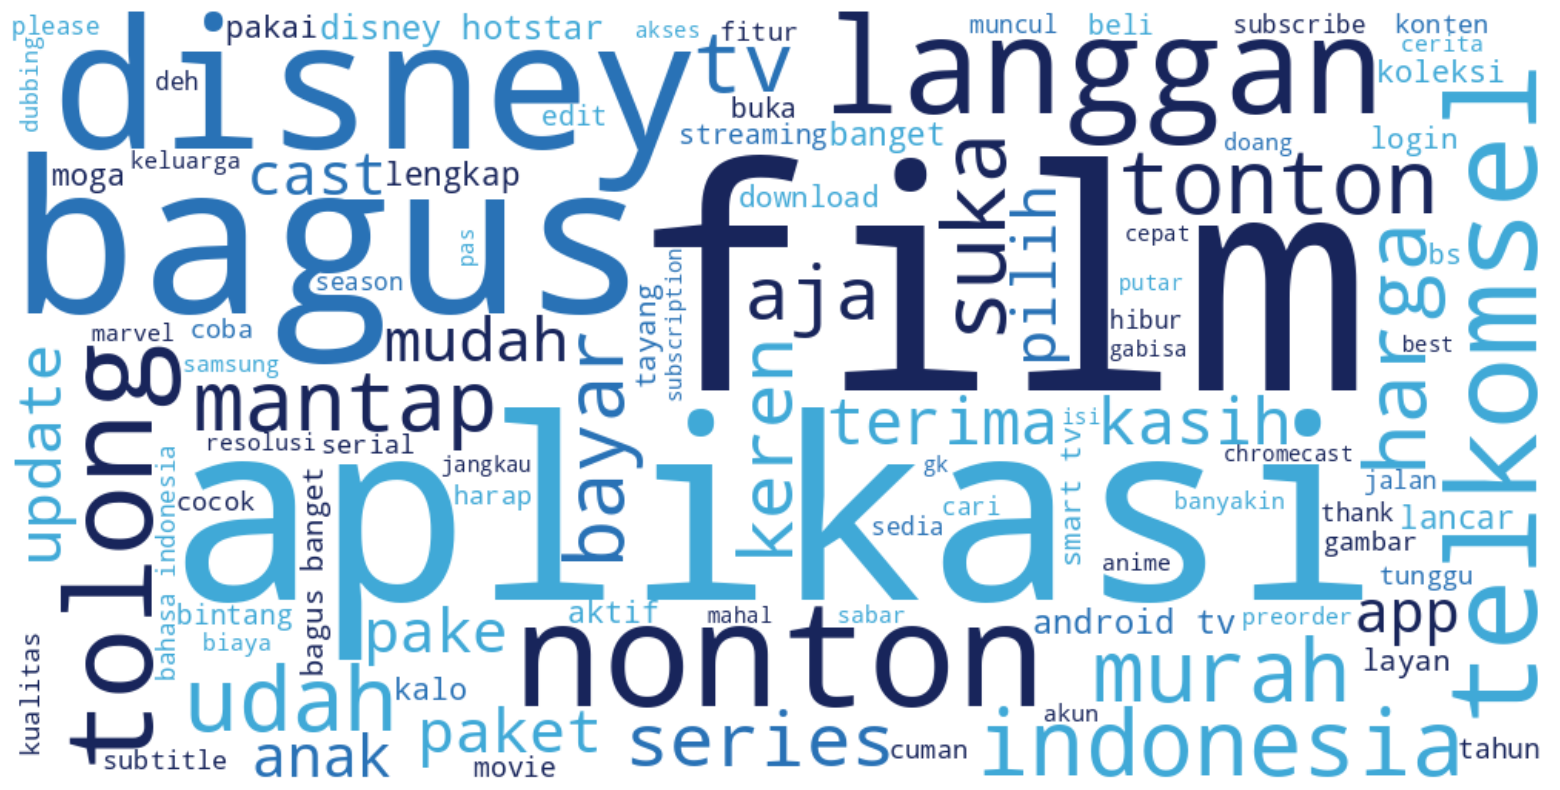

In [ ]:
# Palet warna Disney+
disney_colors = ["#18255b", "#40a9d7", "#2972b6"]
wordcloud_disney5 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=disney_color_func).generate(konten_clean_disneyplus5)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_disney5, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_disneyplus5.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari disneyplus1
texts_disney5 = disneyplus5['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_disney5 = CountVectorizer(ngram_range=(3,3))
x_disney5 = vectorizer_disney5.fit_transform(texts_disney5)

# mengambil daftar trigram + count
trigram_disney5 = vectorizer_disney5.get_feature_names_out()
trigram_counts_disney5 = x_disney5.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_disneyplus5 = pd.DataFrame({
    'Trigram': trigram_disney5,
    'Count': trigram_counts_disney5
})

# urutkan 50 trigram paling sering muncul
trigram_freq_disneyplus5 = trigram_freq_disneyplus5.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_disneyplus5)

Trigram  Count
2128         terima kasih disney      4
632          disney terima kasih      3
1676           pilih film tonton      2
1454             murah moga film      2
2132      terima kasih telkomsel      2
2408             worth it banget      2
2280            tv series disney      2
1147           keren tonton film      2
1109         kasih disney terima      2
132           aplikasi film film      2
2010   subtitle bahasa indonesia      2
113          aplikasi android tv      2
1014      indonesia terima kasih      2
115        aplikasi bagus banget      2
872             gemar berat film      2
353            berat film disney      2
1167        koleksi film lengkap      2
371          biaya langgan murah      2
1666  perangkat selular prosedur      2
1819            samsung smart tv      2
610      disney indonesia terima      2
1515          nonton film disney      2
87                android tv box      2
445      cartoon doraemon series      2
1619            pake jdi inggris      1
1618            pake jaring wifi      1
1595               out list film      1
1617       pake jaring telkomsel      1
1620             pake kabel hdmi      1
1622       pake laptop sambungin      1
1596       overall bagusss cuman      1
1597             overall oke gan      1
1616             pake google pay      1
1598             ovo gopay pulsa      1
1614            pake akun mantan      1
1615         pake chromecast led      1
1599        padat disney hotstar      1
1613         pakai resolusi pros      1
1612    pakai provider telkomsel      1
1611           pakai profil kids      1
1600           pagi gagal muncul      1
1610       pakai paket telkomsel      1
1601       pagi september kontak      1
1602       pagi sms subscription      1
1603         paham bahasa tolong      1
1604       paham resolusi gambar      1
1609            pakai nomor tsel      1
1608           pakai disney plus      1
1605        paham tunggu koleksi      1
1606           pakai cocok pikul      1

In [ ]:
disneyplus5[['content']].to_excel('disneyplus5_content.xlsx', index=False)

# VIU

In [ ]:
# Mengambil ID aplikasi dari Play Store
id2 ='com.vuclip.viu' #isi id disini
viu = scrape_review(lang='id', id_link=id2)
viu

reviewId       userName  \
0       c010d209-5336-4f40-b508-017e7589490b  A Google user   
1       8d4896bb-625e-4cf9-b371-fa64ee737f0f  A Google user   
2       7cd62bd4-4d82-43ea-9a87-943ec284fc8a  A Google user   
3       76911216-2195-4b4a-accc-1d9007ae7314  A Google user   
4       67411c8a-968c-4a7e-b08d-765fb0283545  A Google user   
...                                      ...            ...   
109314  a62ee5f2-78e2-42a6-ba95-c7618f7d4131  A Google user   
109315  9448c1cd-61e3-4691-b730-5e91422e44e5  A Google user   
109316  683f3514-2973-4fe5-be66-910a7d345170  A Google user   
109317  067ecd32-cb27-4592-9510-14177adc4785  A Google user   
109318  ed348c03-1855-4e36-adf0-d5e089afc575  A Google user   

                                                userImage  \
0       https://play-lh.googleusercontent.com/EGemoI2N...   
1       https://play-lh.googleusercontent.com/EGemoI2N...   
2       https://play-lh.googleusercontent.com/EGemoI2N...   
3       https://play-lh.googleusercontent.com/EGemoI2N...   
4       https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                   ...   
109314  https://play-lh.googleusercontent.com/EGemoI2N...   
109315  https://play-lh.googleusercontent.com/EGemoI2N...   
109316  https://play-lh.googleusercontent.com/EGemoI2N...   
109317  https://play-lh.googleusercontent.com/EGemoI2N...   
109318  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                  content  score  \
0       I really enjoy using the Viu app. It has a wid...      5   
1       worst app. I don't mind watching ads, but your...      1   
2       Already paid premium but need to see ads for e...      3   
3             way too many ads, unwatchable for free user      1   
4                                                     👍👍👍      4   
...                                                   ...    ...   
109314  Nice user interface, nice video quality on low...      5   
109315                                 Superb, all in one      5   
109316                                         Awesome!!!      5   
109317  It's Amazing! catch all your favourite shows, ...      5   
109318  Best app so far in premium video market. You g...      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0                 None 2025-12-29 17:23:38   
1                   0               2.21.0 2025-12-29 13:50:52   
2                   0               2.22.1 2025-12-29 12:41:16   
3                   0                 None 2025-12-28 18:31:20   
4                   0               2.17.1 2025-12-28 11:12:28   
...               ...                  ...                 ...   
109314              4                1.0.0 2016-02-19 13:33:37   
109315              0                 None 2016-02-19 02:39:58   
109316              1                1.0.0 2016-02-18 06:49:34   
109317             18                1.0.0 2016-02-16 12:43:40   
109318             20                1.0.0 2016-02-16 12:31:37   

                                             replyContent           repliedAt  \
0                                                    None                 NaT   
1                                                    None                 NaT   
2                                                    None                 NaT   
3                                                    None                 NaT   
4       Hi Raisha. Terimakasih sudah menggunakan aplik... 2025-12-28 11:37:13   
...                                                   ...                 ...   
109314                                               None                 NaT   
109315                                               None                 NaT   
109316                                               None                 NaT   
109317                                               None                 NaT   
109318                                       

In [ ]:
viu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109319 entries, 0 to 109318
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              109319 non-null  object        
 1   userName              109319 non-null  object        
 2   userImage             109319 non-null  object        
 3   content               109316 non-null  object        
 4   score                 109319 non-null  int64         
 5   thumbsUpCount         109319 non-null  int64         
 6   reviewCreatedVersion  69671 non-null   object        
 7   at                    109319 non-null  datetime64[ns]
 8   replyContent          84130 non-null   object        
 9   repliedAt             84130 non-null   datetime64[ns]
 10  appVersion            69671 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 9.2+ MB


In [ ]:
# deteksi bahasa langsung pada dataframe dari Play Store
viu["lang"] = viu["content"].astype(str).apply(detect_lang)

# filter hanya Indonesia
viu = viu[viu["lang"] == "id"]

viu

reviewId       userName  \
7       8cc939fb-94a5-409b-8c97-f5c2fb956867  A Google user   
9       d7e7fdf5-9a65-42a0-b36e-ffbfab7c8709  A Google user   
11      02379a94-aad0-4d55-a7b8-9b7e7a306a24  A Google user   
18      2bb29528-cb8a-4ecd-b1f3-ada0024c85bc  A Google user   
24      f39c257f-0a88-4cb3-a101-3eb496f0070e  A Google user   
...                                      ...            ...   
109166  99ec36ed-e464-49ad-8796-6d12b03373fc  A Google user   
109182  397514f5-b599-4629-9797-8f194190621c  A Google user   
109242  d398aab7-f8f8-41e3-b487-b8c6ee568621  A Google user   
109250  0707bddd-7385-403d-ad69-fcaa4966792f  A Google user   
109312  143046be-ab68-4a37-ad4f-5d6b71391072  A Google user   

                                                userImage  \
7       https://play-lh.googleusercontent.com/EGemoI2N...   
9       https://play-lh.googleusercontent.com/EGemoI2N...   
11      https://play-lh.googleusercontent.com/EGemoI2N...   
18      https://play-lh.googleusercontent.com/EGemoI2N...   
24      https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                   ...   
109166  https://play-lh.googleusercontent.com/EGemoI2N...   
109182  https://play-lh.googleusercontent.com/EGemoI2N...   
109242  https://play-lh.googleusercontent.com/EGemoI2N...   
109250  https://play-lh.googleusercontent.com/EGemoI2N...   
109312  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                  content  score  \
7       ikannya ga ngotak 1 episode lebih dari 5 iklan...      1   
9                    kebanyakan iklan kalo gak premium hm      1   
11                    tanggapan atas keluhan sangat cepat      5   
18                       sekarang ga bisa redeem kode ya?      1   
24      iklan terlalu banyakkkk, sampe 8 iklan?4? deng...      1   
...                                                   ...    ...   
109166                                Something different      5   
109182  Nak Tanya adakah vu Malaysia produksi yang sam...      5   
109242  can you fix subtitle movie Prem ratan dhan pay...      2   
109250                                         Saya Kadar      1   
109312                                     my k-drama fix      5   

        thumbsUpCount reviewCreatedVersion                  at  \
7                   0                 None 2025-12-27 16:55:51   
9                   0               2.22.1 2025-12-27 11:32:03   
11                  0               2.22.1 2025-12-27 08:02:23   
18                  1                 None 2025-12-25 05:54:49   
24                  0               2.20.0 2025-12-24 02:19:27   
...               ...                  ...                 ...   
109166              0                 None 2016-03-03 10:27:17   
109182              1                 None 2016-03-02 13:37:58   
109242              6                1.0.2 2016-02-28 15:11:03   
109250              1                 None 2016-02-27 20:18:38   
109312              3                1.0.0 2016-02-21 07:12:51   

                                             replyContent           repliedAt  \
7       Hi Aisyah, terima kasih atas feedback-nya! Kam... 2025-12-28 02:26:00   
9       Hi Nurinayah, terima kasih atas feedback-nya! ... 2025-12-27 11:40:42   
11      Hi Lydia. Terimakasih sudah menggunakan aplika... 2025-12-27 08:06:13   
18      Hi Viuers, mohon maaf atas ketidaknyamanannya,... 2025-12-25 05:57:43   
24      Hi Dina, terima kasih atas feedback-nya! Kami ... 2025-12-24 02:23:54   
...                                                   ...                 ...   
109166                                               None                 NaT   
109182                                               None                 NaT   
109242  Your wish is our command! The issue has been r... 2016-03-10 07:22:01   
109250  Hi Sawn, \n\nDo let us know what shows are you... 2016-02-28 05:59:51   
109312                                       

In [ ]:
columns_to_drop = ['reviewCreatedVersion','replyContent','repliedAt','userImage']
existing_columns = [col for col in columns_to_drop if col in viu.columns]
viu = viu.drop(columns=existing_columns, axis=1)
viu

reviewId       userName  \
7       8cc939fb-94a5-409b-8c97-f5c2fb956867  A Google user   
9       d7e7fdf5-9a65-42a0-b36e-ffbfab7c8709  A Google user   
11      02379a94-aad0-4d55-a7b8-9b7e7a306a24  A Google user   
18      2bb29528-cb8a-4ecd-b1f3-ada0024c85bc  A Google user   
24      f39c257f-0a88-4cb3-a101-3eb496f0070e  A Google user   
...                                      ...            ...   
109166  99ec36ed-e464-49ad-8796-6d12b03373fc  A Google user   
109182  397514f5-b599-4629-9797-8f194190621c  A Google user   
109242  d398aab7-f8f8-41e3-b487-b8c6ee568621  A Google user   
109250  0707bddd-7385-403d-ad69-fcaa4966792f  A Google user   
109312  143046be-ab68-4a37-ad4f-5d6b71391072  A Google user   

                                                  content  score  \
7       ikannya ga ngotak 1 episode lebih dari 5 iklan...      1   
9                    kebanyakan iklan kalo gak premium hm      1   
11                    tanggapan atas keluhan sangat cepat      5   
18                       sekarang ga bisa redeem kode ya?      1   
24      iklan terlalu banyakkkk, sampe 8 iklan?4? deng...      1   
...                                                   ...    ...   
109166                                Something different      5   
109182  Nak Tanya adakah vu Malaysia produksi yang sam...      5   
109242  can you fix subtitle movie Prem ratan dhan pay...      2   
109250                                         Saya Kadar      1   
109312                                     my k-drama fix      5   

        thumbsUpCount                  at appVersion lang  
7                   0 2025-12-27 16:55:51       None   id  
9                   0 2025-12-27 11:32:03     2.22.1   id  
11                  0 2025-12-27 08:02:23     2.22.1   id  
18                  1 2025-12-25 05:54:49       None   id  
24                  0 2025-12-24 02:19:27     2.20.0   id  
...               ...                 ...        ...  ...  
109166              0 2016-03-03 10:27:17       None   id  
109182              1 2016-03-02 13:37:58       None   id  
109242              6 2016-02-28 15:11:03      1.0.2   id  
109250              1 2016-02-27 20:18:38       None   id  
109312              3 2016-02-21 07:12:51      1.0.0   id  

[5774 rows x 8 columns]

In [ ]:
viu.isnull().sum()

reviewId            0
userName            0
content             0
score               0
thumbsUpCount       0
at                  0
appVersion       1189
lang                0
dtype: int64

In [ ]:
viu["appVersion"] = viu["appVersion"].fillna(
    viu
    .groupby(viu["at"].dt.month)["appVersion"]
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

viu.isnull().sum()

reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
appVersion       0
lang             0
dtype: int64

In [ ]:
# Jumlah Rating Aplikasi
viu['score'].value_counts()

score
1    2557
5    1055
3     834
2     801
4     527
Name: count, dtype: int64

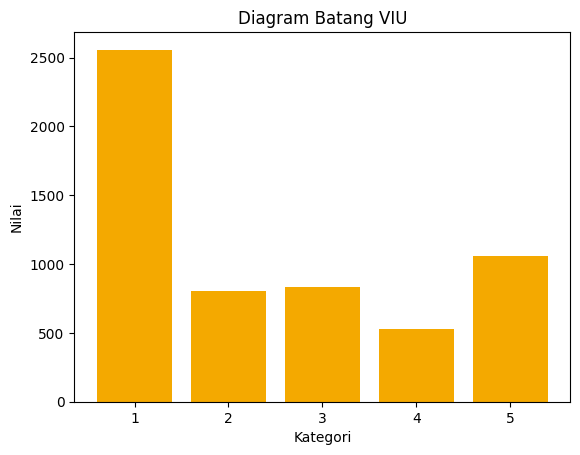

In [ ]:
# Diagram Batang Aplikasi
score_viu = viu['score'].value_counts().sort_index()

# Membuat diagram batang dengan warna VIU
plt.bar(score_viu.index, score_viu.values, color="#f4a900")

# Judul dan label
plt.title("Diagram Batang VIU")
plt.xlabel("Kategori")
plt.ylabel("Nilai")

# Tampilkan grafik
plt.show()


In [ ]:
# Rata-rata Rating Per Tahun
waktu_viu = viu['score'].groupby(viu['at'].dt.year).mean()
waktu_viu

at
2016    3.326389
2017    2.675000
2018    2.830189
2019    2.481977
2020    2.375094
2021    2.351876
2022    2.422983
2023    1.910569
2024    1.920188
2025    1.957055
Name: score, dtype: float64

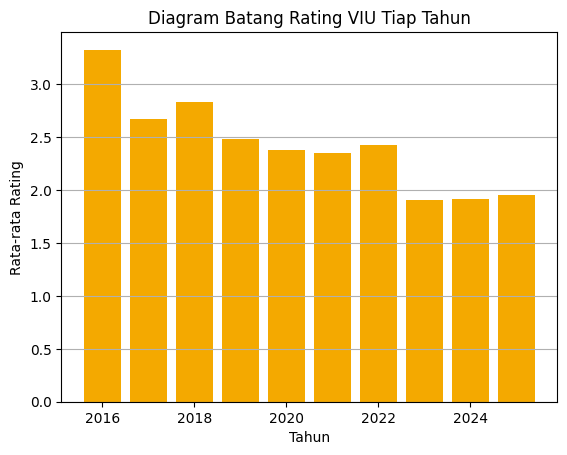

In [ ]:
# Visualisasi Rating apps setiap tahun
score_viu_1 = viu['score'].groupby(viu['at'].dt.year).mean()

# Membuat diagram batang
plt.bar(score_viu_1.index, score_viu_1.values, color="#f4a900")

# Judul dan label
plt.title("Diagram Batang Rating VIU Tiap Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Rating")

# Tampilkan grid
plt.grid(axis='y')
plt.show()

## Analisis Rating 1 dan 5 dari Aplikasi VIU

In [ ]:
viu1 = viu[viu["score"] == 1].copy()
viu5 = viu[viu["score"] == 5].copy()

### Rating 1 VIU

In [ ]:
clean = []
kosong = []
for j, i in enumerate(viu1['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

viu1['clean content'] = clean
kosong

[156, 1178, 1999, 2253, 2520, 2556]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']   #list stop words bisa ditambahkan sendiri
stopwords_indo.extend(tambahan)

konten_clean_viu1 = ""

for index, row in viu1.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_viu1 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_viu1

'ikan ngotak episode iklan durasi menit rang plis iklan kalo premium hm redeem kode iklan banyakkkk sampe iklan durasi detik viu kebelet haji lu ape viu udah upg premium then said upgrade premium no wonder rate lu jelek opening bikin sakit trus suruh upgrade premium login device email and emailing you guys just wasting of time no solution so better you fix your apps instead than telling us to contact your css beli vip log out apps vip hilang log in gk vip beli internet datakenapa bukak eror gajelas prabayar kecewa gabisa buka tulis koneksi internet bagus sia sia udah premium jelek aplikasi udah pake premium bayar lumayan mahal tt tampil gk lengkap aplikasi coba contoh aplikasi iqiyi wetv netflix aplikasi entertainment gitu aksesibilitas susah cari tonton spesifik sesuai genre karna pilih bingung nonton sinopsis lengkap terang drama genre dll app eror kesel iklan too much gila iklan ngotak nonton iklan asa gratis iklan fiks ganti aplikasi dah update review downgrade star udah langgan ta

In [ ]:
clean = []
kosong = []

for j, row in viu1.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
viu1['clean content'] = clean

print(kosong)

[2629, 37627, 73752, 94942, 104867, 109250]


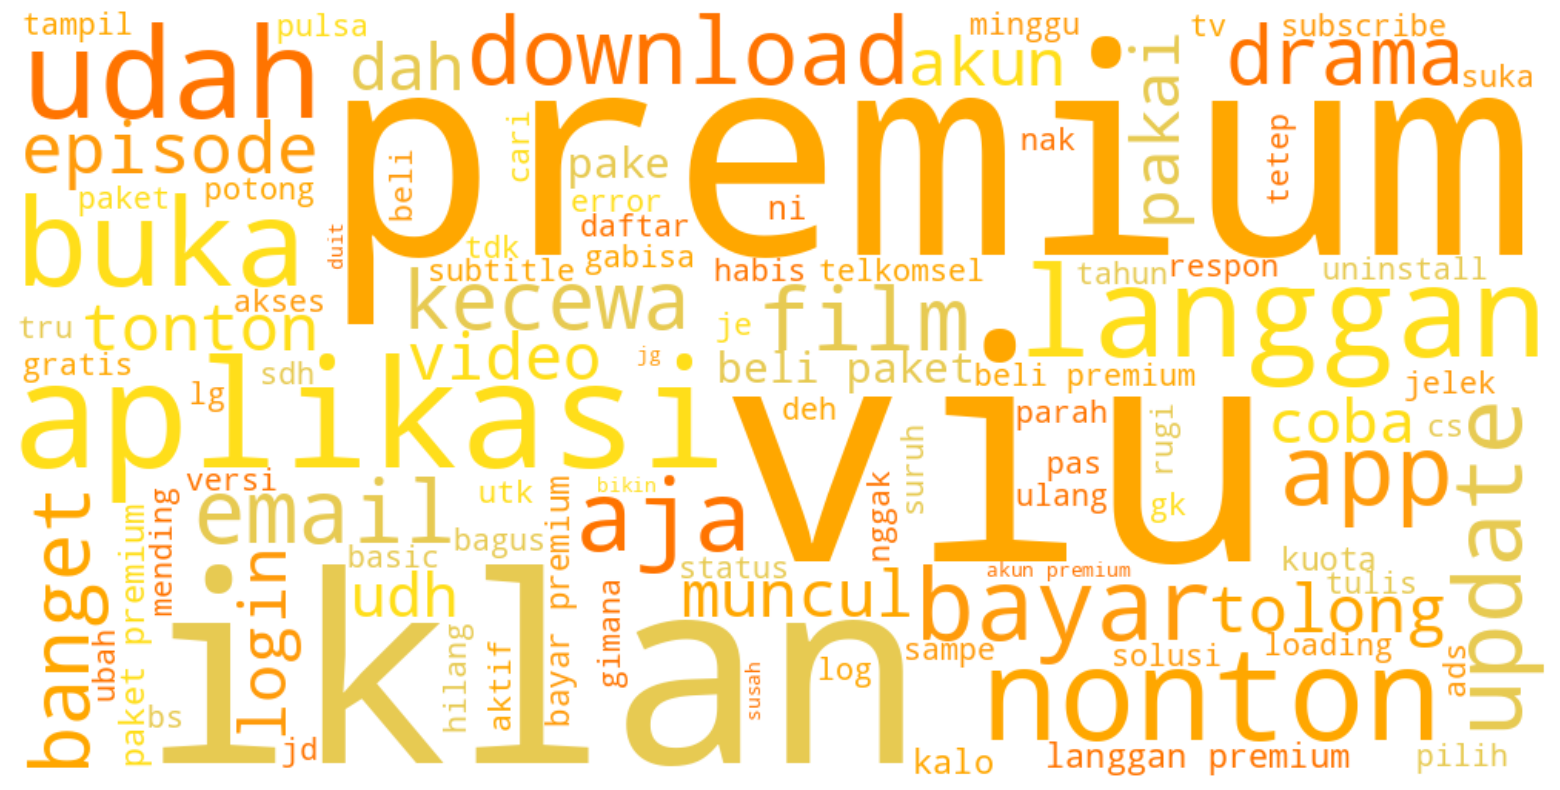

In [ ]:
# Palet warna Viu
viu_colors = ["#ff7400", "#ffa700", "#ffde1a", "#e7ca52", "#ff9b0b"]

# Fungsi warna acak
def viu_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(viu_colors)
wordcloud_viu1 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=viu_color_func).generate(konten_clean_viu1)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_viu1, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_viu1.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari VIU1
texts_viu1 = viu1['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_viu1 = CountVectorizer(ngram_range=(3,3))
x_viu1 = vectorizer_viu1.fit_transform(texts_viu1)

# mengambil daftar trigram + count
trigram_viu1 = vectorizer_viu1.get_feature_names_out()
trigram_counts_viu1 = x_viu1.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_viu1 = pd.DataFrame({
    'Trigram': trigram_viu1,
    'Count': trigram_counts_viu1
})

# urutkan 50 trigram paling sering muncul
trigram_freq_viu1 = trigram_freq_viu1.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_viu1)

Trigram  Count
2959        beli paket premium     45
23159        udah beli premium     17
23296     udah langgan premium     14
23158          udah beli paket     14
23142       udah bayar premium     12
2975            beli paket viu     11
23737  uninstall install ulang     10
2964      beli paket telkomsel      9
12360      langgan viu premium      9
2626       bayar paket premium      8
5100         dah bayar premium      8
16188        paket premium viu      8
9582           in your country      8
16946            please fix it      7
2952        beli paket langgan      6
10178    jelek banget aplikasi      6
25069         viu sedia negara      6
2638        bayar premium akun      6
2579     bayar langgan premium      6
23655      unavailable in your      5
15208     nonton video premium      5
11409       komplain via email      5
2882         beli akun premium      5
23443           udh beli paket      5
18320        pulsa udah potong      5
14994       nonton drama korea      5
2943           beli paket data      5
11328           kode otp kirim      5
1251     aplikasi jelek banget      4
2686       bayar premium still      4
16172      paket premium tahun      4
16125       paket premium beli      4
16160      paket premium paket      4
2537         bayar google play      4
23682    uninstal instal ulang      4
9431           iklan udah gitu      4
11101        kirim bukti bayar      4
5141       dah langgan premium      4
5610              did you know      4
4088        buka video premium      4
4967    customer service buruk      4
1256       aplikasi jelek udah      4
15259         not available in      4
17876      premium still basic      4
4752    coba uninstall install      4
25455              why why why      3
14136            muncul pop up      3
19019       saldo gopay potong      3
23342        udah pake premium      3
16030     paket dasar komplain      3

In [ ]:
viu1[['content']].to_excel('VIU1_content.xlsx', index=False)

### Rating 5 VIU

In [ ]:
clean = []
kosong = []
for j, i in enumerate(viu5['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

viu5['clean content'] = clean
kosong

[189, 632, 637, 875]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']
stopwords_indo.extend(tambahan)

konten_clean_viu5 = ""

for index, row in viu5.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_viu5 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_viu5

'tanggap keluh cepat udah connect thank you moga stabil tingkat dh bayar utk premium tpi knpa free user customer service bagus tanggap cepat tuntas episode running man lengkap tahuntahun senang tonton ulang episode harap lengkap semangat tambahin vitur speed up still suka viu lately ni kuat loading nak internet problem apps okay je love the content please fix pasal loading ni jenuh dah refresh suka viu karna jernih uiux tolong letak tonton senang org tua tonton drama terima kasih xde citer bestberbulan citer samabayar vip rm citer xde loff banget app seru nge drakor layan drama best pilih film kualitas bagus banget nonton kak pas iklan film henti sebentar tuh film jalan pas muncul iklan makasih sblmnya tangan adu konsumen cepat terimakasih sinyal lemottt layan csnya khususon kak andra kak kevin terima kasih merespon email viu premium nyala yeay nonton conan bebas iklan love asi movies bagus alam penstriman viu best layan movie hii viusaya bayar langgan minggu apk ubah hongkong ubah fre

In [ ]:
clean = []
kosong = []

for j, row in viu5.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
viu5['clean content'] = clean

print(kosong)

[17794, 69506, 70245, 97791]


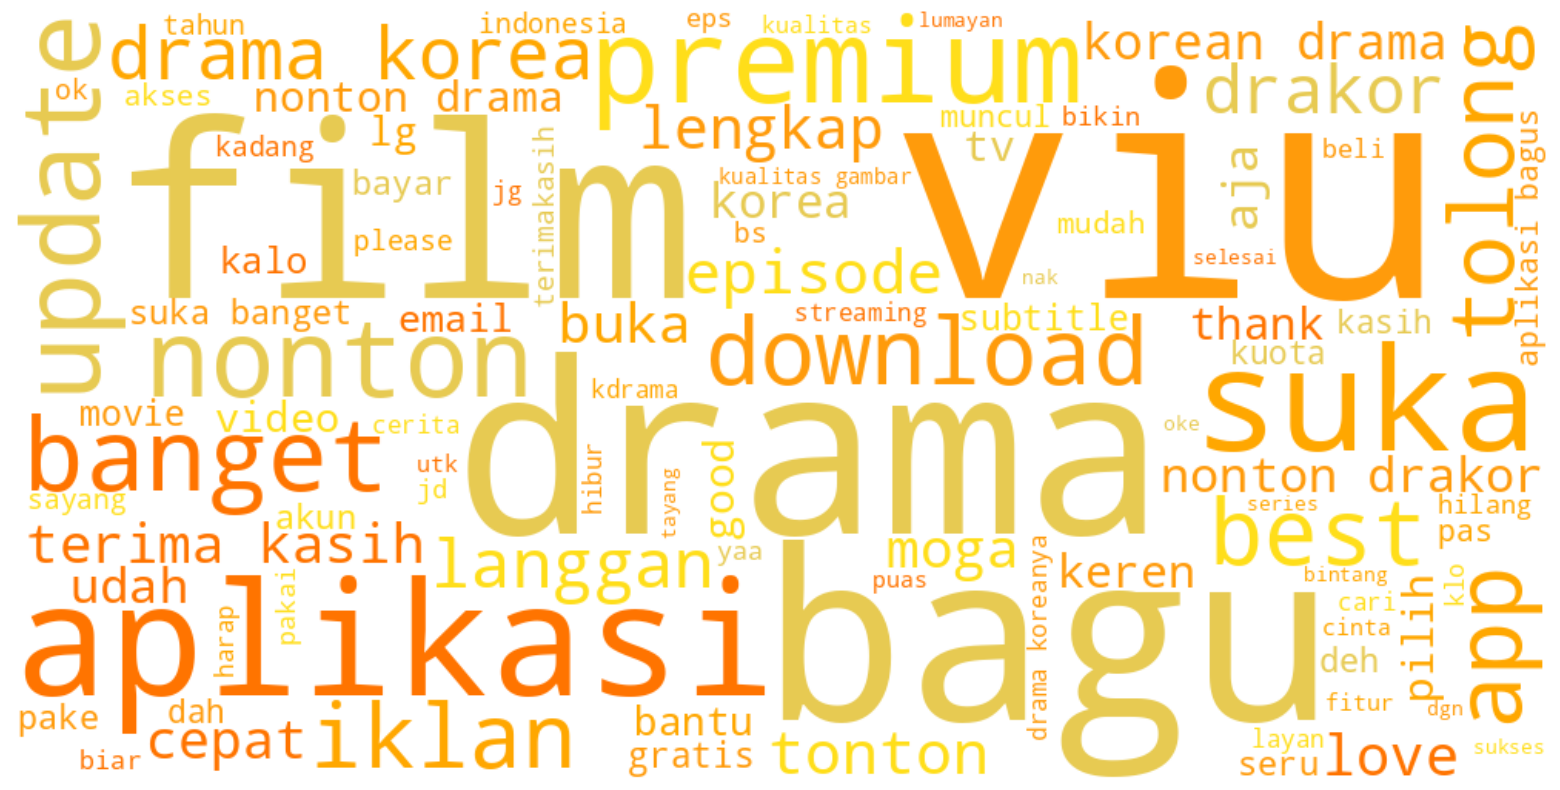

In [ ]:
# Palet warna Viu
viu_colors = ["#ff7400", "#ffa700", "#ffde1a", "#e7ca52", "#ff9b0b"]
wordcloud_viu5 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=viu_color_func).generate(konten_clean_viu5)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_viu5, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_viu5.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari VIU5
texts_viu5 = viu5['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_viu5 = CountVectorizer(ngram_range=(3,3))
x_viu5 = vectorizer_viu5.fit_transform(texts_viu5)

# mengambil daftar trigram + count
trigram_viu5 = vectorizer_viu5.get_feature_names_out()
trigram_counts_viu5 = x_viu5.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_viu5 = pd.DataFrame({
    'Trigram': trigram_viu5,
    'Count': trigram_counts_viu5
})

# urutkan 50 trigram paling sering muncul
trigram_freq_viu5 = trigram_freq_viu5.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_viu5)

Trigram  Count
3712         nonton drama korea     17
5138           terima kasih viu      8
5546                 up to date      7
5801           viu nonton drama      6
3262              love this app      5
4716                  so far so      5
4805  subtitle bahasa indonesia      5
1574           drama korea suka      4
481          bagus nonton drama      4
4402        running man lengkap      4
429         bagus banget nonton      4
142                and love you      4
1821                far so good      4
1556        drama korea favorit      4
247       aplikasi nonton drama      4
2413                is the best      4
1765        episode running man      4
1511          drama drama korea      3
767           best korean drama      3
4535       selesai terima kasih      3
1597     drama koreanya lengkap      3
2962      kualitas gambar bagus      3
587        banget nonton drakor      3
3482              much and love      3
3726          nonton film drama      3
1466        drakor variety show      3
4723                so much and      3
3193          like korean drama      3
1985           for korean drama      3
3698         nonton drakor puas      3
2910            korean drama in      3
710          beli paket premium      3
5119         terima kasih bantu      3
5851           viu terima kasih      3
5907      watching korean drama      3
3267                love you so      3
1947          film variety show      3
4862            suka banget viu      3
4891         suka nonton drakor      3
1944           film utama drama      3
5984                you so much      3
207          aplikasi bagus tpi      2
117            akun viu premium      2
4387      rilis subtitle bahasa      2
2542                judul oh my      2
714              beli paket viu      2
2918            korean drama so      2
5644          utk nonton drakor      2
3705          nonton drakor viu      2
1639              drama so much      2

In [ ]:
viu5[['content']].to_excel('VIU5_content.xlsx', index=False)

# IQIYI

In [ ]:
# Mengambil ID aplikasi dari Play Store
id3 = 'com.iqiyi.i18n'
iqiyi = scrape_review(id_link=id3)
iqiyi

reviewId       userName  \
0      42936887-9dc1-44d2-bb41-1feee29f8c45  A Google user   
1      72e93093-0e68-4fad-b8a1-bfda073fb1f1  A Google user   
2      1670c6f6-58b3-488d-b7b4-169c38b40580  A Google user   
3      33501772-f12d-437e-947b-8321b1219b22  A Google user   
4      bc691b5c-e992-4985-9e01-81881ace48ee  A Google user   
...                                     ...            ...   
65983  94e8deba-cc3c-43bd-85ee-10f0365ce6f4  A Google user   
65984  42c5a57e-984d-43e7-8d46-0e5a0f119534  A Google user   
65985  ebef151e-04d5-4140-a7a0-17d31fb53e26  A Google user   
65986  4269ad96-c793-43b5-a686-866e525c5e3a  A Google user   
65987  648ddfe0-c3ec-4a43-a243-10559b2f58da  A Google user   

                                               userImage  \
0      https://play-lh.googleusercontent.com/EGemoI2N...   
1      https://play-lh.googleusercontent.com/EGemoI2N...   
2      https://play-lh.googleusercontent.com/EGemoI2N...   
3      https://play-lh.googleusercontent.com/EGemoI2N...   
4      https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
65983  https://play-lh.googleusercontent.com/EGemoI2N...   
65984  https://play-lh.googleusercontent.com/EGemoI2N...   
65985  https://play-lh.googleusercontent.com/EGemoI2N...   
65986  https://play-lh.googleusercontent.com/EGemoI2N...   
65987  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
0      Great streaming app with amazing content! iQIY...      5   
1                                        very good shows      5   
2                                           love the app      5   
3                               it is veryy good app 😎😎🤗      5   
4      just for purchase u should have to add ads for...      2   
...                                                  ...    ...   
65983  if i join vip can i see movie and series with ...      5   
65984                             please english version      5   
65985  please subtitles malay and english.. I don't k...      2   
65986  I really like this iqiyi english version. I ho...      5   
65987                         superb ...fully satisfied😃      5   

       thumbsUpCount reviewCreatedVersion                  at  \
0                  0                 None 2025-12-29 17:30:04   
1                  0               7.11.0 2025-12-29 12:43:46   
2                  0               7.11.0 2025-12-29 09:02:40   
3                  0               7.11.0 2025-12-29 08:59:12   
4                  0                 None 2025-12-29 07:47:09   
...              ...                  ...                 ...   
65983              0                1.2.1 2019-07-18 12:57:06   
65984              0                1.2.1 2019-07-18 11:30:14   
65985              3                1.2.1 2019-07-17 11:30:50   
65986             39                1.2.1 2019-07-15 18:03:23   
65987              3                 None 2019-07-12 14:37:31   

                                            replyContent           repliedAt  \
0                                                   None                 NaT   
1                                                   None                 NaT   
2                                                   None                 NaT   
3                                                   None                 NaT   
4                                                   None                 NaT   
...                                                  ...                 ...   
65983  Dear sir/madam, as we need more information to... 2019-07-18 15:28:00   
65984  Dear sir/madam, there was language settings in... 2019-07-18 15:24:52   
65985  Dear sir/madam, please kindly claim your troub... 2019-07-19 06:26:16   
65986  Thanks for supporting iQIYI. We will work hard... 2019-07-16 02:15:12   
65987  Thanks for supporting iQIYI. We will work hard... 2019-07-15 03:18:20   

      appVersion  
0  

In [ ]:
iqiyi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65988 entries, 0 to 65987
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              65988 non-null  object        
 1   userName              65988 non-null  object        
 2   userImage             65988 non-null  object        
 3   content               65987 non-null  object        
 4   score                 65988 non-null  int64         
 5   thumbsUpCount         65988 non-null  int64         
 6   reviewCreatedVersion  44605 non-null  object        
 7   at                    65988 non-null  datetime64[ns]
 8   replyContent          23699 non-null  object        
 9   repliedAt             23699 non-null  datetime64[ns]
 10  appVersion            44605 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 5.5+ MB


In [ ]:
# deteksi bahasa langsung pada dataframe dari Play Store
iqiyi["lang"] = iqiyi["content"].astype(str).apply(detect_lang)

# filter hanya Indonesia
iqiyi = iqiyi[iqiyi["lang"] == "id"]

iqiyi

reviewId       userName  \
30     e6fc5d32-059f-4488-b5d5-2aaba1ba62ec  A Google user   
57     ed259e82-414c-4a69-a8d2-e8b3a9ac6fa0  A Google user   
74     b5f9ec14-8486-40f7-8b3c-f20236bf18f4  A Google user   
146    4bb23dd5-bffe-4293-801e-2528359ee175  A Google user   
197    a7c96ffc-e2dd-4bc5-8b85-9147cc9abde7  A Google user   
...                                     ...            ...   
65306  f65cb326-f90c-456f-8680-bb022333c6a4  A Google user   
65458  310e974a-1f61-47bb-9fc2-e9c9f7efecb6  A Google user   
65498  c1f2227d-0ffa-4a19-be7c-2b93b9978946  A Google user   
65615  90b5f54f-09fe-4dc5-aef2-10c0539bb7f8  A Google user   
65953  4fc1d350-cfb6-4a6c-8d77-1da2382c7e9a  A Google user   

                                               userImage  \
30     https://play-lh.googleusercontent.com/EGemoI2N...   
57     https://play-lh.googleusercontent.com/EGemoI2N...   
74     https://play-lh.googleusercontent.com/EGemoI2N...   
146    https://play-lh.googleusercontent.com/EGemoI2N...   
197    https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
65306  https://play-lh.googleusercontent.com/EGemoI2N...   
65458  https://play-lh.googleusercontent.com/EGemoI2N...   
65498  https://play-lh.googleusercontent.com/EGemoI2N...   
65615  https://play-lh.googleusercontent.com/EGemoI2N...   
65953  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
30     kenapa dah subscribe puh masih ada iklan...har...      3   
57                            so many ads , banyak iklan      1   
74                       lahat may VIP di sya nakakatuwa      2   
146    kenapa saya sudah berlangganan dan sudah terba...      2   
197                      Some interesting drama to watch      5   
...                                                  ...    ...   
65306                             Tidak update drama nya      1   
65458                            Aplikasi yg sngat bagus      5   
65498  Buat people +62... saya cuma' mau ngasih tau a...      4   
65615            Gratis cuma 2 episode. Sisanya bayar. 😴      2   
65953                               bagus untuk ditonton      5   

       thumbsUpCount reviewCreatedVersion                  at  \
30                 0               7.11.0 2025-12-27 04:59:59   
57                 0                 None 2025-12-24 19:18:09   
74                 0               7.11.0 2025-12-23 08:14:27   
146                0                 None 2025-12-17 10:45:22   
197                0               7.11.0 2025-12-11 23:38:11   
...              ...                  ...                 ...   
65306              0                1.7.0 2019-11-15 07:39:38   
65458              0                 None 2019-10-30 15:07:29   
65498              0                1.5.0 2019-10-29 10:58:55   
65615              0                 None 2019-10-08 12:44:01   
65953              0                1.2.3 2019-08-01 20:59:32   

                                            replyContent           repliedAt  \
30                                                  None                 NaT   
57                                                  None                 NaT   
74                                                  None                 NaT   
146                                                 None                 NaT   
197                                                 None                 NaT   
...                                                  ...                 ...   
65306  Sila berikan nama drama dan nombor episode ber... 2019-11-25 08:32:37   
65458  Kami akan terus berusaha untuk memberikan pela... 2019-11-01 06:28:53   
65498  Dikarenakan adanya pembatasan hak cipta, beber... 2019-11-22 09:24:06   
65615  Anda bisa mencoba berlangganan VIP, setelah lo... 2019-10-09 07:42:48   
65953  Thanks for supporting iQIYI. We will work hard... 2019-08-02 13:40:18   

      appVersion lang 

In [ ]:
columns_to_drop = ['reviewCreatedVersion','replyContent','repliedAt','userImage']
existing_columns = [col for col in columns_to_drop if col in iqiyi.columns]
iqiyi = iqiyi.drop(columns=existing_columns, axis=1)
iqiyi

reviewId       userName  \
30     e6fc5d32-059f-4488-b5d5-2aaba1ba62ec  A Google user   
57     ed259e82-414c-4a69-a8d2-e8b3a9ac6fa0  A Google user   
74     b5f9ec14-8486-40f7-8b3c-f20236bf18f4  A Google user   
146    4bb23dd5-bffe-4293-801e-2528359ee175  A Google user   
197    a7c96ffc-e2dd-4bc5-8b85-9147cc9abde7  A Google user   
...                                     ...            ...   
65306  f65cb326-f90c-456f-8680-bb022333c6a4  A Google user   
65458  310e974a-1f61-47bb-9fc2-e9c9f7efecb6  A Google user   
65498  c1f2227d-0ffa-4a19-be7c-2b93b9978946  A Google user   
65615  90b5f54f-09fe-4dc5-aef2-10c0539bb7f8  A Google user   
65953  4fc1d350-cfb6-4a6c-8d77-1da2382c7e9a  A Google user   

                                                 content  score  \
30     kenapa dah subscribe puh masih ada iklan...har...      3   
57                            so many ads , banyak iklan      1   
74                       lahat may VIP di sya nakakatuwa      2   
146    kenapa saya sudah berlangganan dan sudah terba...      2   
197                      Some interesting drama to watch      5   
...                                                  ...    ...   
65306                             Tidak update drama nya      1   
65458                            Aplikasi yg sngat bagus      5   
65498  Buat people +62... saya cuma' mau ngasih tau a...      4   
65615            Gratis cuma 2 episode. Sisanya bayar. 😴      2   
65953                               bagus untuk ditonton      5   

       thumbsUpCount                  at appVersion lang  
30                 0 2025-12-27 04:59:59     7.11.0   id  
57                 0 2025-12-24 19:18:09       None   id  
74                 0 2025-12-23 08:14:27     7.11.0   id  
146                0 2025-12-17 10:45:22       None   id  
197                0 2025-12-11 23:38:11     7.11.0   id  
...              ...                 ...        ...  ...  
65306              0 2019-11-15 07:39:38      1.7.0   id  
65458              0 2019-10-30 15:07:29       None   id  
65498              0 2019-10-29 10:58:55      1.5.0   id  
65615              0 2019-10-08 12:44:01       None   id  
65953              0 2019-08-01 20:59:32      1.2.3   id  

[1277 rows x 8 columns]

In [ ]:
iqiyi.isnull().sum()

reviewId           0
userName           0
content            0
score              0
thumbsUpCount      0
at                 0
appVersion       400
lang               0
dtype: int64

In [ ]:
iqiyi["appVersion"] = iqiyi["appVersion"].fillna(
    iqiyi
    .groupby(iqiyi["at"].dt.month)["appVersion"]
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

iqiyi.isnull().sum()

reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
appVersion       0
lang             0
dtype: int64

In [ ]:
# Jumlah Rating Aplikasi
iqiyi['score'].value_counts()

score
5    561
1    419
4    125
3     97
2     75
Name: count, dtype: int64

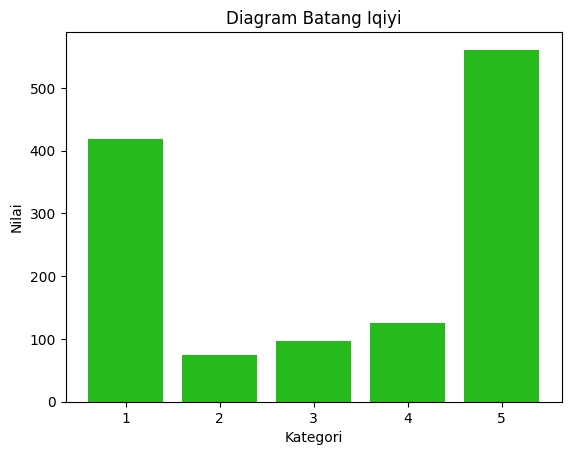

In [ ]:
# Diagram Batang Aplikasi
score_iqiyi = iqiyi['score'].value_counts().sort_index()

# Membuat diagram batang dengan warna Iqiyi
plt.bar(score_iqiyi.index, score_iqiyi.values, color="#26ba1c")

# Judul dan label
plt.title("Diagram Batang Iqiyi")
plt.xlabel("Kategori")
plt.ylabel("Nilai")

# Tampilkan grafik
plt.show()


In [ ]:
# Rata-rata Rating Per Tahun
waktu_iqiyi = iqiyi['score'].groupby(iqiyi['at'].dt.year).mean()
waktu_iqiyi

at
2019    3.166667
2020    3.450980
2021    3.735593
2022    2.573477
2023    2.382716
2024    2.603774
2025    2.953125
Name: score, dtype: float64

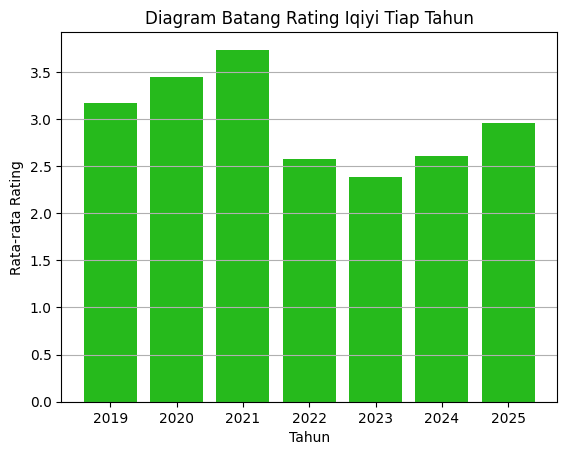

In [ ]:
# Visualisasi Rating apps setiap tahun
score_iqiyi_1 = iqiyi['score'].groupby(iqiyi['at'].dt.year).mean()

# Membuat diagram batang
plt.bar(score_iqiyi_1.index, score_iqiyi_1.values, color="#26ba1c")

# Judul dan label
plt.title("Diagram Batang Rating Iqiyi Tiap Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Rating")

# Tampilkan grid
plt.grid(axis='y')
plt.show()

## Analisis Rating 1 dan 5 dari Aplikasi Iqiyi

In [ ]:
iqiyi1 = iqiyi[iqiyi["score"] == 1].copy()
iqiyi5 = iqiyi[iqiyi["score"] == 5].copy()

### Rating 1 Iqiyi

In [ ]:
clean = []
kosong = []
for j, i in enumerate(iqiyi1['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

iqiyi1['clean content'] = clean
kosong

[386, 392, 412]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']   #list stop words bisa ditambahkan sendiri
stopwords_indo.extend(tambahan)

konten_clean_iqiyi1 = ""

for index, row in iqiyi1.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_iqiyi1 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_iqiyi1

'so many ads iklan almost no korean drama in it update bayar notifikasi notif langgan pakai rugi bayar aplikasi bayar promo ribu aplikasi vip klik vip hilang google tv gitu vip vip vip pakainyen anggap regional jepang pakai vpn menu tutup tagih diangapbukan vip mail cs iqiyi via aplikasi response hatihati aplikasi cs indonesia waktu langgan iqiyi udah diingetin sodara kalo promo mesti nambah duit udah bayar episode suruh bayar klo liat eps kapokkkkk kapookkk standard tulis pas bayar error saldo potong nyedot uang layan batal ambil hapus drama bl bl bromance bikin inget yu menglong hapussssss bacot banget maksa rating ganggu zhaolusi drama please gratis tolong udah pake iqiyi bayar ilang gitu aja tolong iqiyi vip film episode macet aneh bayar kalo download byk didownload gratis coba install aplikasi daftar vip urban miracle doctor chanel iqiyi youtube subtitle aplikasi rugi daftar vip iklan nonton menit iklan muncul hadeh muncul gila video sampe muncul iklan ku hapus dah tkde cita drama

In [ ]:
clean = []
kosong = []

for j, row in iqiyi1.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
iqiyi1['clean content'] = clean

print(kosong)

[58489, 59598, 63044]


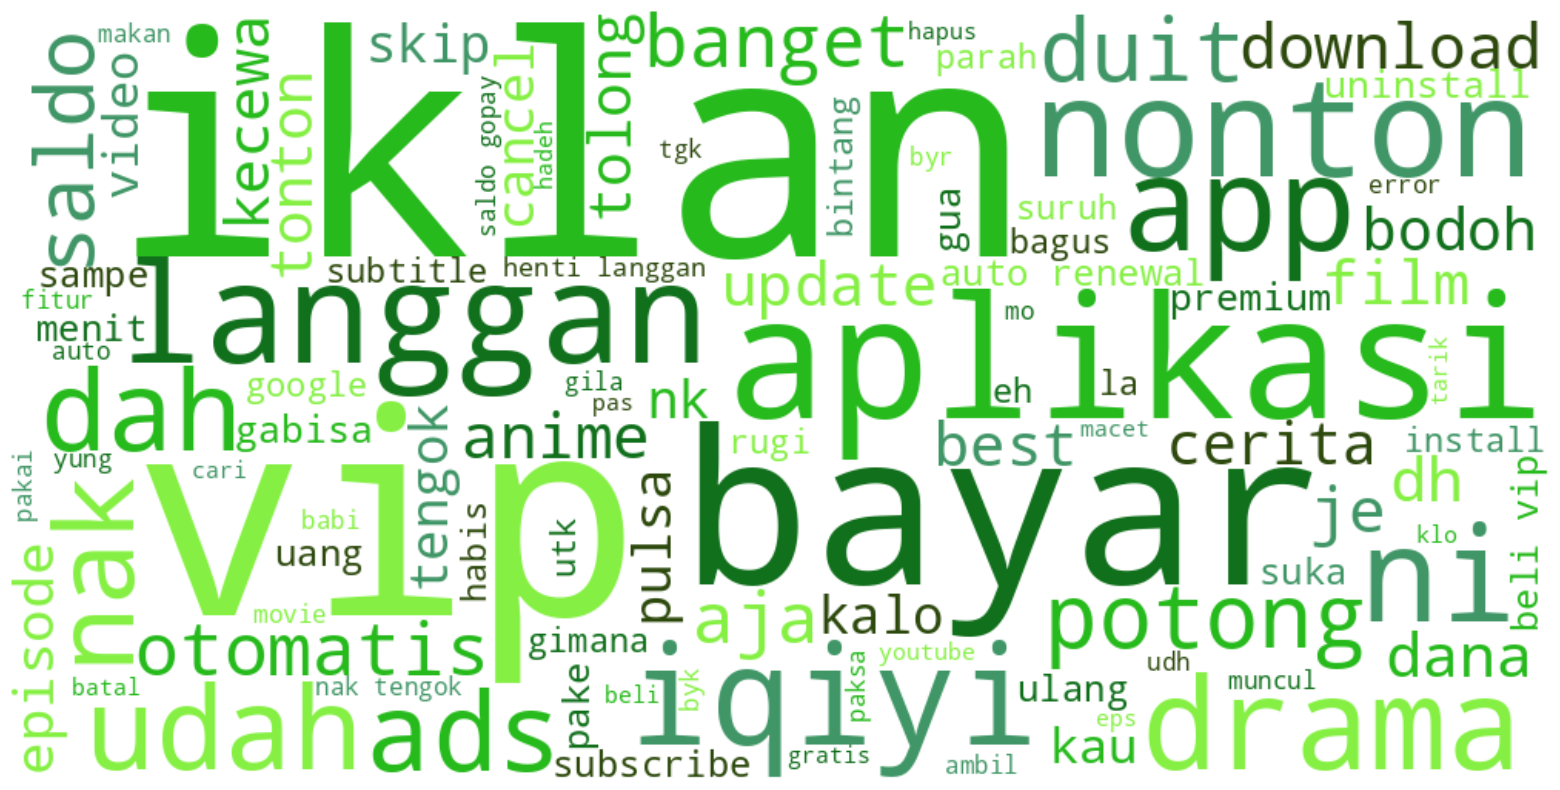

In [ ]:
# Palet warna Iqiyi
iqiyi_colors = ["#2d490d", "#11701c", "#409666", "#26ba1c", "#85f043"]

# Fungsi warna acak
def iqiyi_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(iqiyi_colors)

wordcloud_iqiyi1 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=iqiyi_color_func).generate(konten_clean_iqiyi1)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_iqiyi1, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_iqiyi1.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari iqiyi1
texts_iqiyi1 = iqiyi1['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_iqiyi1 = CountVectorizer(ngram_range=(3,3))
x_iqiyi1 = vectorizer_iqiyi1.fit_transform(texts_iqiyi1)

# mengambil daftar trigram + count
trigram_iqiyi1 = vectorizer_iqiyi1.get_feature_names_out()
trigram_counts_iqiyi1 = x_iqiyi1.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_iqiyi1 = pd.DataFrame({
    'Trigram': trigram_iqiyi1,
    'Count': trigram_counts_iqiyi1
})

# urutkan 50 trigram paling sering muncul
trigram_freq_iqiyi1 = trigram_freq_iqiyi1.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_iqiyi1)

Trigram  Count
952             iklan ulang ulang      2
1138             kimetsu no yaiba      2
969            inang auto renewal      2
863            henti langgan uang      2
495                  dah beli vip      2
1695              potong duit dlm      2
103               apk gjls banget      2
421                   byr utk vip      2
1591            or movie sedihhhh      1
1592               org bayar pake      1
1593           orng bijak pundekk      1
1594                   otak ka li      1
1595         otomatis banget cari      1
1597            otomatis duit gue      1
1598            otomatis gara apk      1
1599       otomatis langgan narik      1
1600        otomatis pantes saldo      1
1601           otomatis pas kasih      1
1602           otomatis rugi user      1
1603           otomatis vip bayar      1
1596          otomatis dana sedot      1
1573  obatkalah youtubeapps teruk      1
1574                  of mahu ads      1
1575             of spotless mind      1
1576     offline koneksi internet      1
1577          offline salah putar      1
1578             oh gustong gusto      1
1579                 oiii vip pon      1
1580                   ok nmn sya      1
1590                    or jgn bg      1
1582                oke iklan jir      1
1583               okey tipu duit      1
1584              okin nam potang      1
1585               oklah eh iklan      1
1586                   on dah vip      1
1587                 once may vip      1
1588              one piece hapus      1
1589              oqng tkmau beli      1
1604             otomatis vip tdk      1
1581                  okay je vip      1
1624          paksa uninstall apl      1
1625          paksa uninstall bye      1
1626          palang vip mapanood      1
1627           pandai kau plikasi      1
1628              panget neto may      1
1629          panoorin yung drama      1
1630            pantes saldo dana      1
1631                papa iklan gk      1
1605      pakai giftmoney sengkek      1
1633             parah full iklan      1

In [ ]:
iqiyi1[['content']].to_excel('iqiyi1_content.xlsx', index=False)

### Rating 5 Iqiyi

In [ ]:
clean = []
kosong = []
for j, i in enumerate(iqiyi5['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

iqiyi5['clean content'] = clean
kosong

[56, 84, 201, 313, 333, 351, 517]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']
stopwords_indo.extend(tambahan)

konten_clean_iqiyi5 = ""

for index, row in iqiyi5.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_iqiyi5 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_iqiyi5

'some interesting drama to watch hindi mein kaise dekhen subscribe payment data email akun ubah akun google payment udah beli member trus login verification code bs nemu inbox cari bs nemu lg diberitahu sampah udah beli member bs nikmat member iqiyi kalo iklam tiktok pake judul iqiyi cuman bahasa indonesia nyarinya susah kalo pake judul iqiyi nyaa cerita ni layan love iii bagus suka please hindi language me tolong donghua drama iqiyi best cdrama streaming app love you owneranime rata serufilm serudan terima anime film gratiscuma iklan aja wkwkwk tpi no problempokoknya udah bagus lahtpi awas aja kalo iklan judi onlinegw kasih rata aplikasi animenya anak nontonjadi iklan kasih lihatokeditebisa tolong anime stock anime apk suka apps ni best tengok cite thai best tolong improve translation bahasa melayumalay languagejangan machine je pelik subtitle hi my mom loves this app langgan aplikasi main perangkat suka apk iniii iqiyi iebih bagus platform logo kuning nonton drama cina segi gambar uk

In [ ]:
clean = []
kosong = []

for j, row in iqiyi5.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
iqiyi5['clean content'] = clean

print(kosong)

[9341, 13317, 27102, 38347, 41310, 42910, 58001]


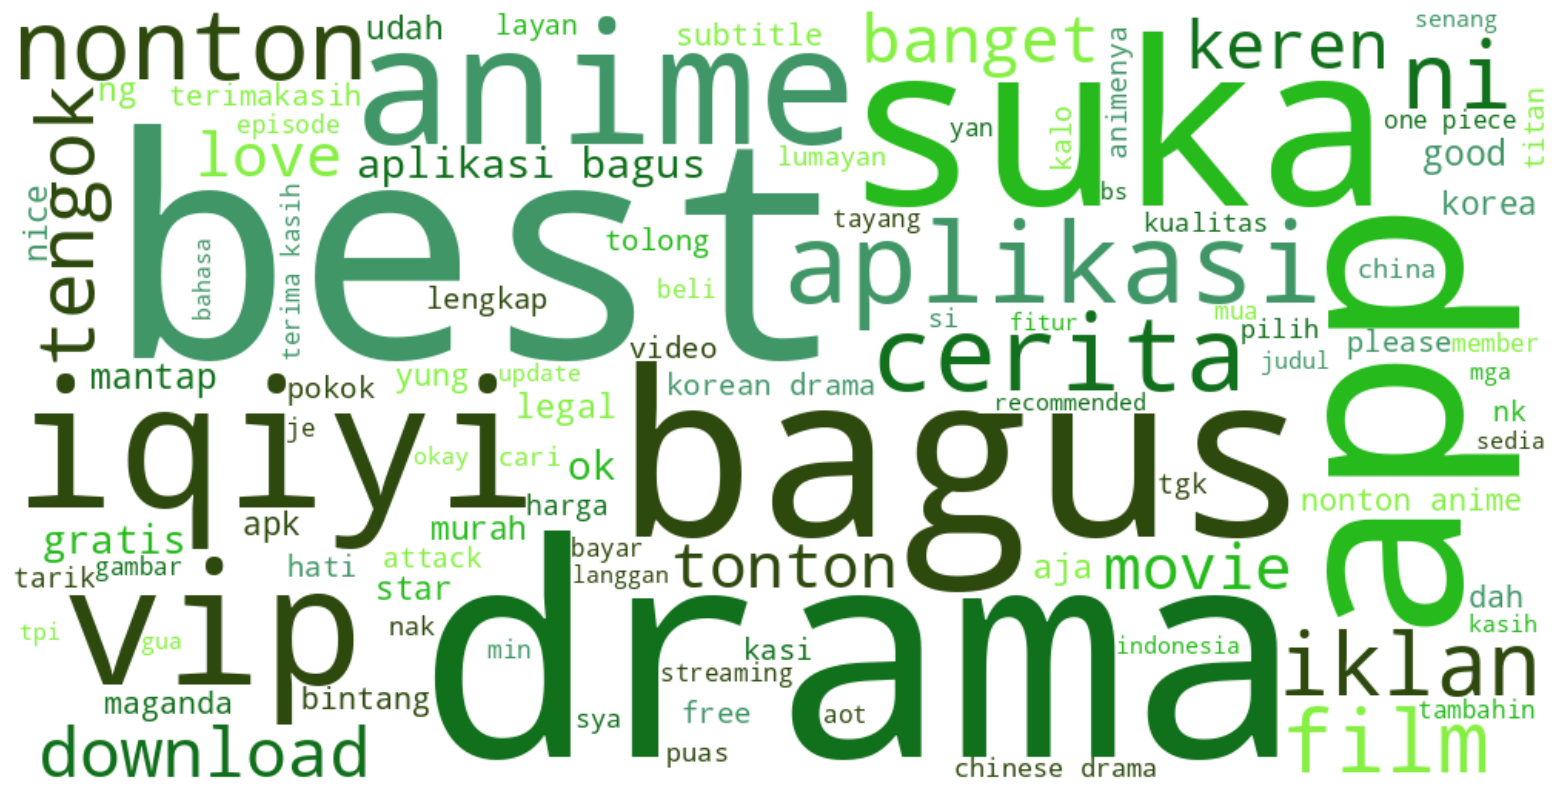

In [ ]:
# Palet warna Iqiyi
iqiyi_colors = ["#2d490d", "#11701c", "#409666", "#26ba1c", "#85f043"]
wordcloud_iqiyi5 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=iqiyi_color_func).generate(konten_clean_iqiyi5)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_iqiyi5, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_iqiyi5.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari iqiyi5
texts_iqiyi5 = iqiyi5['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_iqiyi5 = CountVectorizer(ngram_range=(3,3))
x_iqiyi5 = vectorizer_iqiyi5.fit_transform(texts_iqiyi5)

# mengambil daftar trigram + count
trigram_iqiyi5 = vectorizer_iqiyi5.get_feature_names_out()
trigram_counts_iqiyi5 = x_iqiyi5.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_iqiyi5 = pd.DataFrame({
    'Trigram': trigram_iqiyi5,
    'Count': trigram_counts_iqiyi5
})

# urutkan 50 trigram paling sering muncul
trigram_freq_iqiyi5 = trigram_freq_iqiyi5.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_iqiyi5)

Trigram  Count
218           attack on titan      6
376            best drama app      5
541     chinese drama episode      4
677      drama episode onward      4
1624           pale pale pale      3
668         drama china korea      3
1269        love korean drama      3
2022       terima kasih iqiyi      3
116     aplikasi bagus banget      3
59          anime drama korea      2
1643        perfect drama app      2
1935        suka terima kasih      2
2049           the best pokok      2
513          cerita best best      2
660          drama anime show      2
1914             suka apps ni      2
2041            tgk one piece      2
815             ganda ng apps      2
1943           super ganda ng      2
1618         pake judul iqiyi      2
1519       nonton anime legal      2
1254            like this app      2
1606           onward see you      2
1341         melastik hati mu      2
1530        nonton drama cina      2
1274            love this app      2
2102       tonton cerita best      2
1017              is the best      2
2148         udah beli member      2
142     aplikasi nonton drama      2
748        episode onward see      2
989         iqiyi drama anime      2
261        bagus nonton anime      2
1438           ng mga palabas      2
318         basta maganda sya      2
2004      tengok cerita drama      2
2000      tengok budak tebing      2
2275           youth with you      2
1435               ng apps to      2
1532        nonton drama gitu      1
1444      ngak ribet banyakin      1
1531          nonton drama dg      1
1533   nonton drama mautolong      1
1512  no problempokoknya udah      1
1445       ngantik tara mehus      1
1529     nonton drama chinese      1
1528       nonton drakor puas      1
1527     nonton dimauin karna      1
1446      ngau pangan apooooo      1
1447       ngebug lancar nntn      1

In [ ]:
iqiyi5[['content']].to_excel('iqiyi5_content.xlsx', index=False)

# WeTV

In [ ]:
# Mengambil ID aplikasi dari Play Store
id4 ='com.tencent.qqlivei18n' #isi id disini
wetv = scrape_review(lang='id', id_link=id4)
wetv

reviewId       userName  \
0      ccd99ff2-1d3e-4a8d-ad72-e90d03b495b1  A Google user   
1      60ee26c7-8820-4ab6-826e-bb3b67d89948  A Google user   
2      4571ebb4-6001-480a-9ee8-008fb80dc8ec  A Google user   
3      8a81cd2a-25b2-4530-a0e7-c00f05f85cad  A Google user   
4      b350dd1f-0f69-4c77-a231-2a0d8d051b53  A Google user   
...                                     ...            ...   
53555  1ef92b61-1327-496c-a461-7c49055ed94b  A Google user   
53556  f78e08e9-f3e5-4cad-a702-7b5024fc1304  A Google user   
53557  1d982196-8be4-4736-b09a-aea98acd68a6  A Google user   
53558  0a5e190a-a907-4c5c-a662-d57dbddb1d0b  A Google user   
53559  f7a7c1d3-c95b-466b-889a-4e8e22dd9fb9  A Google user   

                                               userImage  \
0      https://play-lh.googleusercontent.com/EGemoI2N...   
1      https://play-lh.googleusercontent.com/EGemoI2N...   
2      https://play-lh.googleusercontent.com/EGemoI2N...   
3      https://play-lh.googleusercontent.com/EGemoI2N...   
4      https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
53555  https://play-lh.googleusercontent.com/EGemoI2N...   
53556  https://play-lh.googleusercontent.com/EGemoI2N...   
53557  https://play-lh.googleusercontent.com/EGemoI2N...   
53558  https://play-lh.googleusercontent.com/EGemoI2N...   
53559  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
0      WeTV is a solid streaming app that offers a wi...      5   
1                                       It will not open      1   
2      App always halt and closes it self after a few...      4   
3      okay-ish i guess.. the only downside for me is...      3   
4      FYI!! I PAID FOR VIP MEMBERSHIP, LAST NOVEMBER...      1   
...                                                  ...    ...   
53555               Love it Chinese Movie Chinese series      5   
53556  ซีรีย์ดีๆเยอะเลย แต่ Timing ซับไม่ตรงหลายตอนเล...      3   
53557  I hope this app compatible with Samsung Smart ...      4   
53558                      app not supporting Chromecast      3   
53559                       น่าจะมีซีรี่ย์ให้เยอะกว่านี้      3   

       thumbsUpCount reviewCreatedVersion                  at  \
0                  0         5.30.5.16690 2025-12-29 17:20:22   
1                  0                 None 2025-12-29 13:40:43   
2                  0         5.30.5.16690 2025-12-28 16:05:20   
3                  0         5.30.6.16740 2025-12-27 16:33:19   
4                  0         5.30.6.16740 2025-12-27 11:18:28   
...              ...                  ...                 ...   
53555              8            1.1.0.909 2019-01-23 05:18:33   
53556              6            1.1.0.909 2019-01-07 12:18:32   
53557              6            1.0.0.493 2018-12-10 08:07:18   
53558             28            1.0.0.493 2018-11-25 19:55:30   
53559              5            1.0.0.493 2018-11-25 13:00:44   

                                            replyContent           repliedAt  \
0                                                   None                 NaT   
1                                                   None                 NaT   
2      Hi Kak! Mohon maaf atas kendalanya, silakan co... 2025-12-28 16:38:03   
3      Dear User, episodes/titles under Rent/Express ... 2025-12-29 02:00:31   
4      Dear Nina, We're sorry to hear on your subscri... 2025-11-18 01:00:06   
...                                                  ...                 ...   
53555                                        ขอบคุณครับ! 2019-02-02 07:32:53   
53556  ตอนนี้ทางทีมคอนเทนต์กำลังตรวจสอบและแก้ไข ขอบคุ... 2019-02-12 07:47:38   
53557                                  มีมาแน่นอนครับ :D 2019-02-02 07:37:52   
53558           อดใจรอก่อนนะครับ มาแน่นอน\nขอบคุณมากครับ 2019-02-02 07:48:48   
53559  ตอนนี้มีคอนเทนต์มาเพิ่มเยอะเลยครับผม\nตามเราได... 2019-02-02 07:50:07   

         appVersion  


In [ ]:
wetv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53560 entries, 0 to 53559
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              53560 non-null  object        
 1   userName              53560 non-null  object        
 2   userImage             53560 non-null  object        
 3   content               53560 non-null  object        
 4   score                 53560 non-null  int64         
 5   thumbsUpCount         53560 non-null  int64         
 6   reviewCreatedVersion  32854 non-null  object        
 7   at                    53560 non-null  datetime64[ns]
 8   replyContent          2170 non-null   object        
 9   repliedAt             2170 non-null   datetime64[ns]
 10  appVersion            32854 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 4.5+ MB


In [ ]:
# deteksi bahasa langsung pada dataframe dari Play Store
wetv["lang"] = wetv["content"].astype(str).apply(detect_lang)

# filter hanya Indonesia
wetv = wetv[wetv["lang"] == "id"]

wetv

reviewId       userName  \
15     42381e5b-c42d-4fa8-a384-b91bc388f5fb  A Google user   
24     be7465f0-82ba-4f16-8cef-b0f91c159390  A Google user   
31     21992931-1036-424c-8d4b-75026c425d7d  A Google user   
57     387af9fe-2be7-44f4-ba79-8cfa5744e365  A Google user   
59     2d178331-a4be-4b26-8871-fe0dc3a13c62  A Google user   
...                                     ...            ...   
53193  f0d8595d-3924-4cc1-8347-252f4e41c5ea  A Google user   
53216  868d121b-5d60-4681-9322-f85fcbf555f8  A Google user   
53346  39f1d139-f5be-4aba-8391-af243d8a83e9  A Google user   
53361  9614e823-10be-43e6-8b0d-efd800828736  A Google user   
53364  39d72006-2d11-4dcb-b155-dcfd50fb2957  A Google user   

                                               userImage  \
15     https://play-lh.googleusercontent.com/EGemoI2N...   
24     https://play-lh.googleusercontent.com/EGemoI2N...   
31     https://play-lh.googleusercontent.com/EGemoI2N...   
57     https://play-lh.googleusercontent.com/EGemoI2N...   
59     https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
53193  https://play-lh.googleusercontent.com/EGemoI2N...   
53216  https://play-lh.googleusercontent.com/EGemoI2N...   
53346  https://play-lh.googleusercontent.com/EGemoI2N...   
53361  https://play-lh.googleusercontent.com/EGemoI2N...   
53364  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
15     cs nya sangat fast respon dan helpfull banget....      5   
24     padahal saya pakai ini dari dulu, tapi lama ke...      2   
31     Banyak iklan, lemot, subtitle kadang ga ada. s...      1   
57     urdu ma to nahi h drama koi bhi sab chata h k ...      1   
59     Napa dah Love on the Turquoise Land byk bgt ad...      1   
...                                                  ...    ...   
53193                         very good to see yang yang      5   
53216            hindi dubbed series upload karo please.      3   
53346  Sukaaa. Tarif VIP juga terjangkau. Bakal lebih...      4   
53361  bersyukur banget ni app ad,di utube ampir semu...      5   
53364  aplikasi yang sangat menakjubkan.. sangat muda...      5   

       thumbsUpCount reviewCreatedVersion                  at  \
15                 1         5.30.5.16690 2025-12-23 00:23:14   
24                 0         5.30.1.16600 2025-12-19 03:47:01   
31                 0         5.30.1.16600 2025-12-14 14:06:43   
57                 0                 None 2025-12-05 23:47:35   
59                 0         5.28.7.16500 2025-12-04 11:03:17   
...              ...                  ...                 ...   
53193              0                 None 2019-08-11 06:52:59   
53216              0           1.8.0.5173 2019-08-09 14:55:52   
53346              2           1.7.5.5122 2019-07-24 23:19:49   
53361              2           1.7.5.5122 2019-07-15 15:51:13   
53364              3           1.7.5.5114 2019-07-14 02:14:36   

                                            replyContent           repliedAt  \
15     Hi Kak! Terima kasih untuk rating dan review-n... 2025-12-23 02:00:50   
24     Hai Kak! Untuk VIP ngga akan rugi lho.Biaya be... 2025-12-19 04:32:55   
31     Hai, Kak! Mohon maaf sebelumnya ya. Jika tidak... 2025-12-15 02:06:38   
57                                                  None                 NaT   
59                                                  None                 NaT   
...                                                  ...                 ...   
53193                                               None                 NaT   
53216                                               None                 NaT   
53346                                               None                 NaT   
53361                                               None                 NaT   
53364                                               None                 NaT   

         appVersion la

In [ ]:
columns_to_drop = ['reviewCreatedVersion','replyContent','repliedAt','userImage']
existing_columns = [col for col in columns_to_drop if col in wetv.columns]
wetv = wetv.drop(columns=existing_columns, axis=1)
wetv

reviewId       userName  \
15     42381e5b-c42d-4fa8-a384-b91bc388f5fb  A Google user   
24     be7465f0-82ba-4f16-8cef-b0f91c159390  A Google user   
31     21992931-1036-424c-8d4b-75026c425d7d  A Google user   
57     387af9fe-2be7-44f4-ba79-8cfa5744e365  A Google user   
59     2d178331-a4be-4b26-8871-fe0dc3a13c62  A Google user   
...                                     ...            ...   
53193  f0d8595d-3924-4cc1-8347-252f4e41c5ea  A Google user   
53216  868d121b-5d60-4681-9322-f85fcbf555f8  A Google user   
53346  39f1d139-f5be-4aba-8391-af243d8a83e9  A Google user   
53361  9614e823-10be-43e6-8b0d-efd800828736  A Google user   
53364  39d72006-2d11-4dcb-b155-dcfd50fb2957  A Google user   

                                                 content  score  \
15     cs nya sangat fast respon dan helpfull banget....      5   
24     padahal saya pakai ini dari dulu, tapi lama ke...      2   
31     Banyak iklan, lemot, subtitle kadang ga ada. s...      1   
57     urdu ma to nahi h drama koi bhi sab chata h k ...      1   
59     Napa dah Love on the Turquoise Land byk bgt ad...      1   
...                                                  ...    ...   
53193                         very good to see yang yang      5   
53216            hindi dubbed series upload karo please.      3   
53346  Sukaaa. Tarif VIP juga terjangkau. Bakal lebih...      4   
53361  bersyukur banget ni app ad,di utube ampir semu...      5   
53364  aplikasi yang sangat menakjubkan.. sangat muda...      5   

       thumbsUpCount                  at    appVersion lang  
15                 1 2025-12-23 00:23:14  5.30.5.16690   id  
24                 0 2025-12-19 03:47:01  5.30.1.16600   id  
31                 0 2025-12-14 14:06:43  5.30.1.16600   id  
57                 0 2025-12-05 23:47:35          None   id  
59                 0 2025-12-04 11:03:17  5.28.7.16500   id  
...              ...                 ...           ...  ...  
53193              0 2019-08-11 06:52:59          None   id  
53216              0 2019-08-09 14:55:52    1.8.0.5173   id  
53346              2 2019-07-24 23:19:49    1.7.5.5122   id  
53361              2 2019-07-15 15:51:13    1.7.5.5122   id  
53364              3 2019-07-14 02:14:36    1.7.5.5114   id  

[1007 rows x 8 columns]

In [ ]:
wetv.isnull().sum()

reviewId           0
userName           0
content            0
score              0
thumbsUpCount      0
at                 0
appVersion       323
lang               0
dtype: int64

In [ ]:
wetv["appVersion"] = wetv["appVersion"].fillna(
    wetv
    .groupby(wetv["at"].dt.month)["appVersion"]
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

wetv.isnull().sum()

reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
appVersion       0
lang             0
dtype: int64

In [ ]:
# Jumlah Rating Aplikasi
wetv['score'].value_counts()

score
1    379
5    296
3    131
4    101
2    100
Name: count, dtype: int64

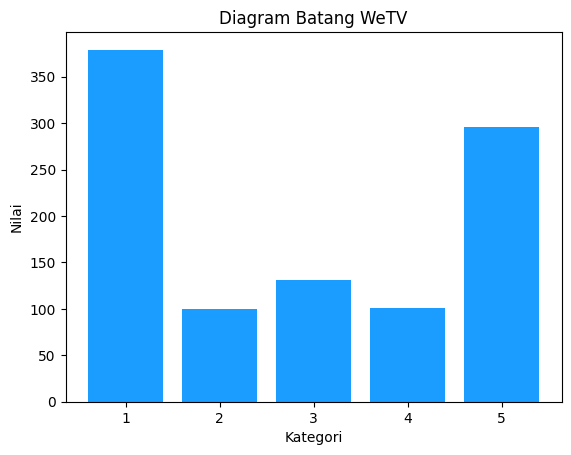

In [ ]:
# Diagram Batang Aplikasi
score_wetv = wetv['score'].value_counts().sort_index()

# Membuat diagram batang dengan warna Wetv
plt.bar(score_wetv.index, score_wetv.values, color="#1b9dff")

# Judul dan label
plt.title("Diagram Batang WeTV")
plt.xlabel("Kategori")
plt.ylabel("Nilai")

# Tampilkan grafik
plt.show()


In [ ]:
# Rata-rata Rating Per Tahun
waktu_wetv = wetv['score'].groupby(wetv['at'].dt.year).mean()
waktu_wetv

at
2019    3.541667
2020    3.345550
2021    3.059524
2022    2.440000
2023    2.760563
2024    2.115385
2025    2.146341
Name: score, dtype: float64

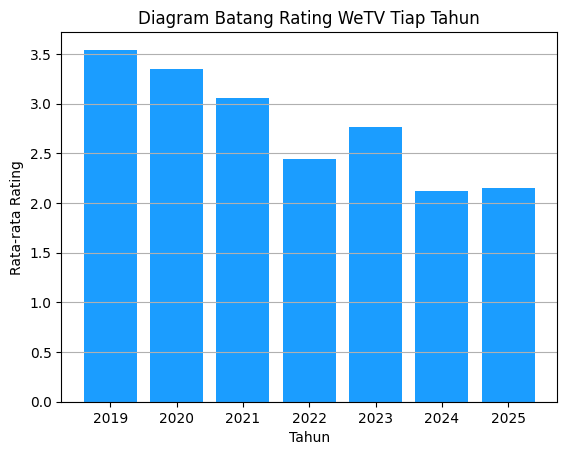

In [ ]:
score_wetv_1 = wetv['score'].groupby(wetv['at'].dt.year).mean()

# Membuat diagram batang (warna WeTV)
plt.bar(score_wetv_1.index, score_wetv_1.values, color="#1b9dff")

# Judul dan label
plt.title("Diagram Batang Rating WeTV Tiap Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Rating")

# Tampilkan grid
plt.grid(axis='y')
plt.show()

## Analisis Rating 1 dan 5 dari Aplikasi WeTV

In [ ]:
wetv1 = wetv[wetv["score"] == 1].copy()
wetv5 = wetv[wetv["score"] == 5].copy()

### Rating 1 WeTV

In [ ]:
clean = []
kosong = []
for j, i in enumerate(wetv1['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

wetv1['clean content'] = clean
kosong

[]

In [ ]:
tambahan = ['gimana','kalo', 'aja', 'udah','udh', 'pas', 'dah','app','tonton','aplikasi', 'apk',
            'banget','nonton','beli', 'beli vip','daftar','langgan', 'langganan','bayar vip','film','drama',
            'episode','video' ,'tv','bayar vip', 'coba','suka',  'kecewa', 'muncul','tetap','gitu', 'parah',
            'tetep', 'apps', 'jelek', 'bikin', 'bagus', 'buruk', 'aneh', 'join vip', 'ma', 'pake',
              'gabisa', 'rugi', 'sampah', 'tolong', 'gopay', 'log', 'gua', 'wetv','free','tayang','fast track','join','apps','waktu',
            'males', 'ganggu', 'cek','bantu', 'tengok', 'duit', 'suruh', 'nggak', 'minggu','susah','liat', 'mas', 'kadang', 'klo',
            'sumpah' , 'lot', 'lg', 'sdh', 'urdu', 'ang', 'dri', 'youtube', 'dri', 'gaada', 'eh',
            'rb', 'tdk' , 'payah', 'kesel', 'org', 'ng', 'je', 'main', 'kayak', 'shopee', 'ribet', 'bs', 'habis la', 'ku', 'trus',
            'tibatiba', 'mending', 'sampe', 'kagak', 'nak', 'kaya', 'oke', 'mulu', 'hindi', 'tau', 'nk',
            'hati', 'beda', 'yung', 'tengah', 'jd', 'la', 'kocak', 'tpi', 'tuh', 'capek', 'debet', 'utk',
            'seri', 'gin', 'busuk', 'ngaco', 'balikin', 'baja', 'ambil', 'jahat', 'pop', 'ubah', 'skrg', 'ampun'
            ,'sedia', 'netflix', 'user', 'mah']   #list stop words bisa ditambahkan sendiri
stopwords_indo.extend(tambahan)

konten_clean_wetv1 = ""

for index, row in wetv1.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_wetv1 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_wetv1

'iklan subtitle to nahi koi bhi sab chata korean dekha please karbdo napa love on the turquoise land byk adegan cut sesuai trailer teasernya vip ekspress kalean peras hasil sgt mngecewakan download krn sailor moon lagiii dooong sailor moon nntn iklan vip batas vipbeli iklanya shope in web bayar vip iklan servis subscribe vip jujur bayar worth it next thank you vip msih iklan play pindah woi admin lu kikir devloper bayar vip up lazada up bayar sewa vip serial program express bayar bayar nunggu gratis bayar vip bagal update nito error mask hasil tendang vip sesal subtitle nyambung tahun subtitle rewatch subtitlenya nyambung vip iklan klik diarahin sopi ok bayar vip lo iklan short reelsnya dikenain biaya all epds wth ijo short vip epds bayar ijo bandwidth server buffering resolusi vip bug next pencet next pindah scene closingan iklan percaya vip aktif iklan iklannnnn premium iklan close auto redirect premium subcriber overheat konsumsi baterai iklan pindah website marketplace niat lengkap

In [ ]:
clean = []
kosong = []

for j, row in wetv1.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
wetv1['clean content'] = clean

print(kosong)

[1267, 2411, 2925, 5260, 13467, 20209, 20451]


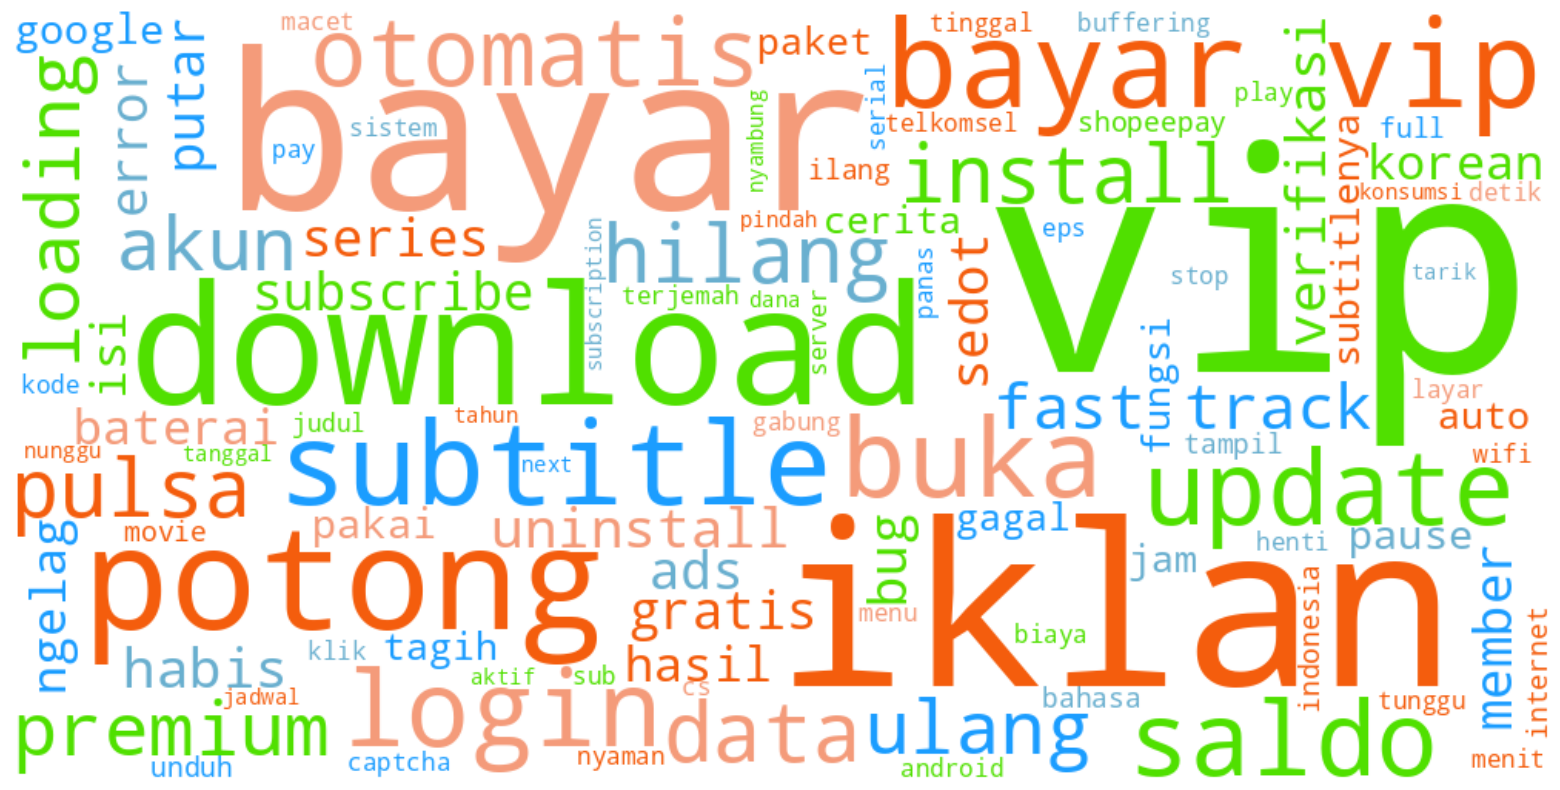

In [ ]:
# Palet warna WeTV
wetv_colors = ["#1b9dff", "#f45d0d", "#50e000", "#f49b7a", "#69afcf"]

# Fungsi warna acak
def wetv_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(wetv_colors)

wordcloud_wetv1 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=wetv_color_func).generate(konten_clean_wetv1)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_wetv1, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_WeTV1.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari wetv1
texts_wetv1 = wetv1['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_wetv1 = CountVectorizer(ngram_range=(3,3))
x_wetv1 = vectorizer_wetv1.fit_transform(texts_wetv1)

# mengambil daftar trigram + count
trigram_wetv1 = vectorizer_wetv1.get_feature_names_out()
trigram_counts_wetv1 = x_wetv1.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_wetv1 = pd.DataFrame({
    'Trigram': trigram_wetv1,
    'Count': trigram_counts_wetv1
})

# urutkan 50 trigram paling sering muncul
trigram_freq_wetv1 = trigram_freq_wetv1.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_wetv1)

Trigram  Count
155               bayar vip bayar      3
721                kode otp kirim      3
27                 akun vip dapet      2
1589              vip sedot pulsa      2
1587             vip pulsa potong      2
603          imperfect the series      2
427              fast track bayar      2
1605              vip ujung bayar      2
1043                  pay for vip      2
159               bayar vip iklan      2
1320        subtitle vip subtitle      2
1111       premium tunggu ngulang      1
1110          premium sadar bayar      1
1109      premium puntengok sikit      1
1108         premium iklan iphone      1
1107          premium iklan close      1
1106      premium iklan beeeeuhhh      1
1105          premium henti error      1
1104        prankbaru download da      1
1112           pria dusta bimbing      1
1102              ppn sesal begok      1
1101           ppn nyacari untung      1
1100           potong vip account      1
1099            potong status vip      1
1098            potong sms potong      1
1097            potong saldo ribu      1
1096      potong saldo konfirmasi      1
1095          potong pulsa bayang      1
1094              potong ovo dana      1
1093   potong otomatis seengaknya      1
1103         praktik ilegal email      1
1139             putri pria dusta      1
1137        putar walopun trailer      1
1136             putar vip simple      1
1135  putar nontonnya subtitlenya      1
1134         putar loading nguwer      1
1133             putar error soul      1
1132        putanginang yan pakyu      1
1131          punyadrama pon best      1
1130     puntengok sikit adssmpai      1
1129              pulsa vip sedot      1
1128             pulsa tarik akun      1
1127         pulsa sedot makasiii      1
1115         profesional nama sub      1
1125           pulsa potong layan      1
1124          pulsa potong hubung      1
1123           pulsa potong hasil      1
1122           pulsa potong claim      1
1121            pulsa jebol saldo      1
1120          pulsa bayang miliar      1

In [ ]:
wetv1[['content']].to_excel('wetv1_content.xlsx', index=False)

### Rating 5 WeTV

In [ ]:
clean = []
kosong = []
for j, i in enumerate(wetv5['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

wetv5['clean content'] = clean
kosong

[32,
 55,
 100,
 109,
 117,
 123,
 127,
 130,
 139,
 146,
 161,
 186,
 190,
 220,
 223,
 248,
 263]

In [ ]:
tambahan = ['moga', 'maganda','ang','kasi','dito','ganda ng','sub','ok','gandang','ganda','terima kasih',
             'please', 'love','ig','ng','layan','terima kasih','tambahin','thank','super','star','bintang',
             'best','pokok','terjemah','sya','good','seru','keren','nice','ni','terimakasih',
             'terima kasih','lahat','rana','puas','naman','yeah','china','mujhe','min','long',
            'serial','korean', 'hindi', 'chinese', 'thailand', 'indonesia','pakai', 'dm','job','bsa','pakai',
            'gk','cari','top','mantap','pati','saran','manood','yung','drakor','nang','deh',
             'ka','kaya','mimin','erti','tahan','indo','harap','cina','mga','dowload','palabas','tarik'
             ,'watching','abis','bohot','bhi','bidadari salju','gampang','kasih','bidadari salju','terima','bidadari saiju',
            'ukur', 'yawa', 'ii', 'mod' , 'lng', 'raja', 'kung', 'bl', 'gara', 'napaka', 'mu', 'kl', 'minat', 'dgn', 'hahahah',
            'wala', 'always', 'gaji', 'temen', 'ung', 'may', 'cuman', 'jarang', 'ukur', 'wilayah', 'kolom', 'thankyou', 'thanks'
            ,'temu', 'huu', 'much', 'jada', 'hi', 'aq', 'ngga', 'napapanood', 'muas', 'pilih', 'achha', 'tuk', 'siya', 'yah', 'mar',
            'dekh', 'loh', 'ki', 'lam', 'mai', 'lumayan', 'bidadari salju',
            ]
stopwords_indo.extend(tambahan)

konten_clean_wetv5 = ""

for index, row in wetv5.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_wetv5 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_wetv5

'cs fast respon helpfull like it dipakenya update animasi donghuanya ditambahin fitur short series series bingung short series series dracin indonya subtitlenya  login kode opt email tiktok resmi login responsible malam vip credit tanggal sept payment vip akun vip member we gerak cepat tangan komplain selesai ringan admin responsif tuntun login selesai gagal login admin ngarahin sukses login kendala hub admin kyk provider merahtau jual paket kendala kirim no screenshot id transaksi metode bayar lokasi detailrtrw lurah kecamatankota saldo potong njirmau ngapain admin ngarahin simple friendly admin widget buka puasa login kode otp kelar fifa arab cup qatar we history update device vip mandarine wtv action fu serusampe panik krn akun prob renew vip akun responnya cepet bangetdan hasil wetvlove filmsangat recommended trouble akun errorvip dipke krna admin responnya cptmslh akun normal member vip trima uplagi judul bahasa inggris mudah cs cepat tanggap solusi salut sukses puter vip chuang p

In [ ]:
clean = []
kosong = []

for j, row in wetv5.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
wetv5['clean content'] = clean

print(kosong)

[169, 2828, 3416, 4741, 4780, 5241, 6596, 7334, 8886, 9596, 9698, 10248, 10370, 10841, 12072, 12506, 12680, 12867, 13472, 14138, 14791, 14930, 16421, 16492, 16567, 21195, 21247, 21447, 25184, 27696, 27891, 29270, 30169, 30172, 32824, 34468, 38390, 38499, 39742, 41329, 42780, 44341, 44568, 48965]


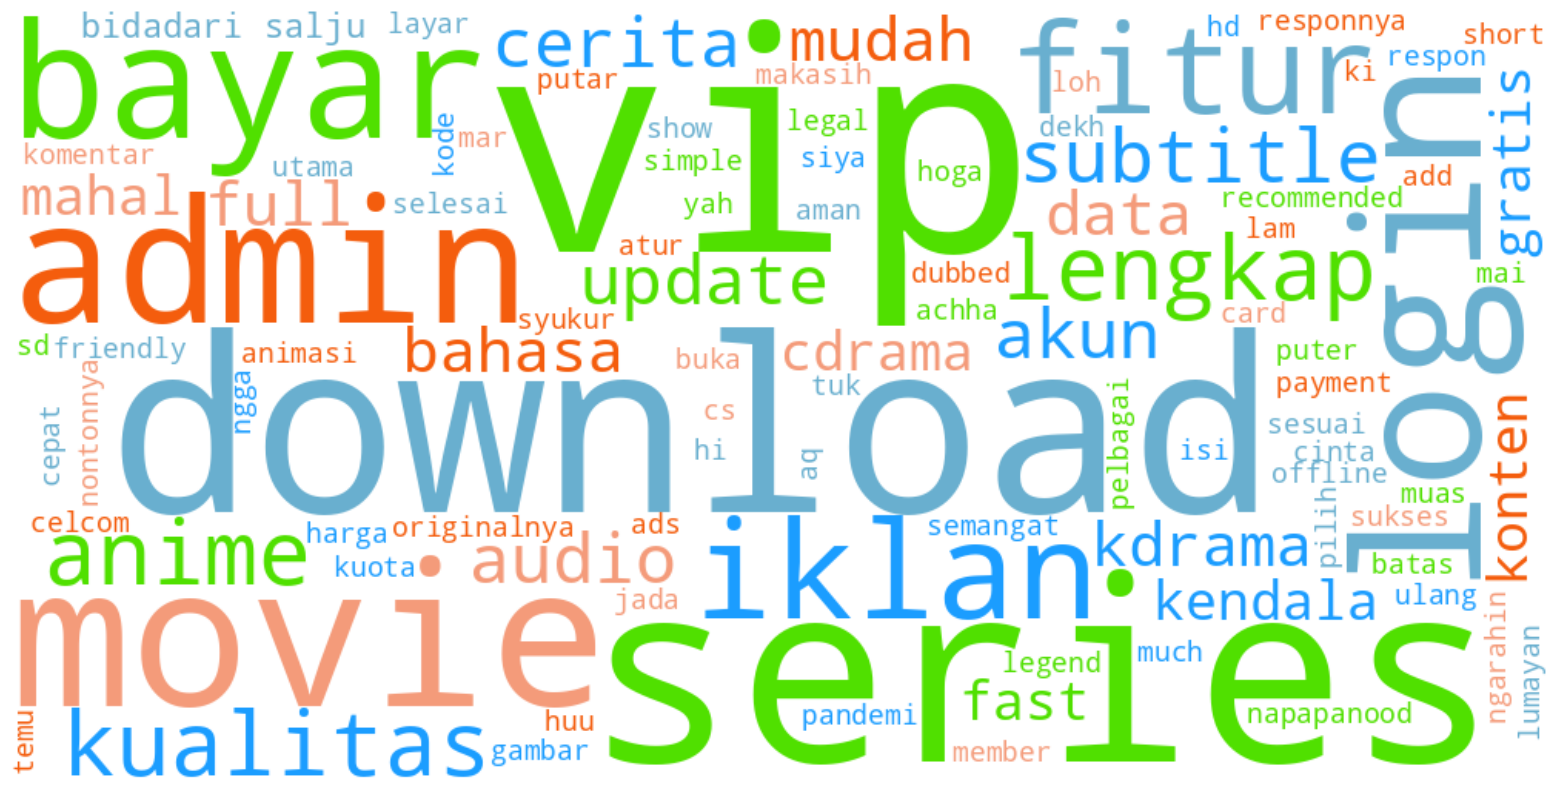

In [ ]:
# Palet warna WeTV
wetv_colors = ["#1b9dff", "#f45d0d", "#50e000", "#f49b7a", "#69afcf"]
wordcloud_wetv5 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=wetv_color_func).generate(konten_clean_wetv5)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_wetv5, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_WeTV5.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari wetv5
texts_wetv5 = wetv5['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_wetv5 = CountVectorizer(ngram_range=(3,3))
x_wetv5 = vectorizer_wetv5.fit_transform(texts_wetv5)

# mengambil daftar trigram + count
trigram_wetv5 = vectorizer_wetv5.get_feature_names_out()
trigram_counts_wetv5 = x_wetv5.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_wetv5 = pd.DataFrame({
    'Trigram': trigram_wetv5,
    'Count': trigram_counts_wetv5
})

# urutkan 50 trigram paling sering muncul
trigram_freq_wetv5 = trigram_freq_wetv5.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_wetv5)

Trigram  Count
260              ganda mga palabas      3
713              short series long      2
703             series long series      2
175                  dekh pati huu      2
206               download sd card      2
747                super ganda mga      2
577                nice appi enjoy      1
579                 nice five star      1
580              nice kaayu lingaw      1
581             niyas maganda siya      1
582          njirmau ngapain admin      1
583      nntnmakasih sub indonesia      1
584               no screenshot id      1
585  nontonnya subtittle indonesia      1
586              normal member vip      1
587      nostalgia layan childhold      1
588               ntn bnyk chinese      1
589               nyaklo long riyi      1
590              nyambung moga lbh      1
591     nyangka konten originalnya      1
592             nyo kayo magsisisi      1
593            of changan pelbagai      1
594                     of fei dsb      1
595                    of my heart      1
596             offline auto kasih      1
597             offline edit fitur      1
598            ok konten indonesia      1
599              ok maganda manood      1
578              nice enjoying the      1
550                  mujhe dena he      1
551                  mujhe me hona      1
552                   mujhe sab hi      1
553               mukang tae bulok      1
554                 my heart thank      1
555                 my lecturer my      1
556                 nahi mujhe sab      1
557            nakakabitin may vip      1
558       nakakaexcite manood ibat      1
559                 naman sya kaso      1
560                nang mga kdrama      1
561                    nang po ito      1
562              napaka ganda nito      1
576             niat pakai praktis      1
564            napapanood kuna ung      1
565         natokaya guys download      1
566           navigasi layar putar      1
567           next banyakin mandar      1
568         ngapain admin ngarahin      1
569            ngarahin dgn simple      1
570          ngarahin sukses login      1

In [ ]:
wetv5[['content']].to_excel('WeTV5_content.xlsx', index=False)

# Vidio

In [ ]:
# Mengambil ID aplikasi dari Play Store
id5 ='com.vidio.android' #isi id disini
vidio = scrape_review(lang='id', id_link=id5)
vidio

reviewId       userName  \
0      8a7e2ef5-eac1-489d-b6ba-fa60f3665e8f  A Google user   
1      04b08a24-8b0f-44d7-9d02-d614abc1218a  A Google user   
2      ad53952b-7953-4b13-bdea-2cb741bb379f  A Google user   
3      1c296c96-fc07-4b7f-a299-166f6298d385  A Google user   
4      4055ffac-8da3-4d5e-982f-9ccea814e759  A Google user   
...                                     ...            ...   
16392  eb29cbcd-b83c-481d-944e-5705d7202643  A Google user   
16393  9c598684-345a-41a7-8631-fd2deea8bafe  A Google user   
16394  f0324da6-37a6-4f58-bf19-736507df756c  A Google user   
16395  8befafa9-e33a-4226-809e-fa9e1126b289  A Google user   
16396  59dcf073-b441-4f1e-84de-1d1203461285  A Google user   

                                               userImage  \
0      https://play-lh.googleusercontent.com/EGemoI2N...   
1      https://play-lh.googleusercontent.com/EGemoI2N...   
2      https://play-lh.googleusercontent.com/EGemoI2N...   
3      https://play-lh.googleusercontent.com/EGemoI2N...   
4      https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
16392  https://play-lh.googleusercontent.com/EGemoI2N...   
16393  https://play-lh.googleusercontent.com/EGemoI2N...   
16394  https://play-lh.googleusercontent.com/EGemoI2N...   
16395  https://play-lh.googleusercontent.com/EGemoI2N...   
16396  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
0                             Tolong batalin paket saya.      2   
1                                               terrible      1   
2      kebanyakan iklan sekarang. jadi buat apa bayar...      1   
3      Ini monetisasi tingkat dewa... Low quality isi...      1   
4                             visual gambar terang cerah      5   
...                                                  ...    ...   
16392                                                Oke      5   
16393                                          Love it..      3   
16394                                    I like this app      5   
16395  Modern ux and look n feel. Good job. Keep goin...      5   
16396                                  Love this app...!      5   

       thumbsUpCount reviewCreatedVersion                  at  \
0                  0                 None 2025-12-29 13:23:04   
1                  0    7.17.9-d633d3aa15 2025-12-29 12:38:01   
2                  0    7.17.9-d633d3aa15 2025-12-28 22:40:59   
3                  4    7.17.9-d633d3aa15 2025-12-28 17:30:31   
4                  0    7.17.9-d633d3aa15 2025-12-28 05:42:02   
...              ...                  ...                 ...   
16392              0                 None 2015-06-12 08:29:14   
16393              0                 None 2015-06-11 14:35:37   
16394              0                  1.2 2015-06-08 13:36:37   
16395              1                 None 2015-05-01 01:25:52   
16396              0             1.0.0002 2015-04-30 17:43:59   

                                            replyContent           repliedAt  \
0      Hai kak. Mohon maaf atas ketidaknyamanan yang ... 2025-12-29 14:48:13   
1      Hi Wan, could you please tell us why do you di... 2025-12-29 15:56:21   
2      Hello, If you're having issues in-app we advis... 2025-12-29 00:01:27   
3      Halo kak, mohon maaf atas ketidaknyamanannya. ... 2025-12-28 19:21:25   
4      Halo Sahabat Vidio, terima kasih banyak atas b... 2025-12-28 06:02:28   
...                                                  ...                 ...   
16392                                               None                 NaT   
16393                                               None                 NaT   
16394                                               None                 NaT   
16395                                               None                 NaT   
16396                                               None                 NaT   

              appVersi

In [ ]:
vidio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16397 entries, 0 to 16396
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              16397 non-null  object        
 1   userName              16397 non-null  object        
 2   userImage             16397 non-null  object        
 3   content               16395 non-null  object        
 4   score                 16397 non-null  int64         
 5   thumbsUpCount         16397 non-null  int64         
 6   reviewCreatedVersion  12761 non-null  object        
 7   at                    16397 non-null  datetime64[ns]
 8   replyContent          14919 non-null  object        
 9   repliedAt             14919 non-null  datetime64[ns]
 10  appVersion            12761 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.4+ MB


In [ ]:
# deteksi bahasa langsung pada dataframe dari Play Store
vidio["lang"] = vidio["content"].astype(str).apply(detect_lang)

# filter hanya Indonesia dan Inggris
vidio = vidio[vidio["lang"] == "id"]

vidio

reviewId       userName  \
0      8a7e2ef5-eac1-489d-b6ba-fa60f3665e8f  A Google user   
2      ad53952b-7953-4b13-bdea-2cb741bb379f  A Google user   
3      1c296c96-fc07-4b7f-a299-166f6298d385  A Google user   
4      4055ffac-8da3-4d5e-982f-9ccea814e759  A Google user   
6      72978812-8c30-44c3-8949-7d17ac3d4fa7  A Google user   
...                                     ...            ...   
16382  24ee6555-d2e1-4563-9cc5-940b06790e97  A Google user   
16384  0b61a931-ce91-41d2-9a46-4614aaef4b7b  A Google user   
16385  b342d077-2512-4e95-94df-a2900c4490fc  A Google user   
16390  93546e5c-56d0-4de4-ae53-de813dec5ab3  A Google user   
16391  18fda4ed-b1a4-4a18-80b9-4d13b99a4b65  A Google user   

                                               userImage  \
0      https://play-lh.googleusercontent.com/EGemoI2N...   
2      https://play-lh.googleusercontent.com/EGemoI2N...   
3      https://play-lh.googleusercontent.com/EGemoI2N...   
4      https://play-lh.googleusercontent.com/EGemoI2N...   
6      https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
16382  https://play-lh.googleusercontent.com/EGemoI2N...   
16384  https://play-lh.googleusercontent.com/EGemoI2N...   
16385  https://play-lh.googleusercontent.com/EGemoI2N...   
16390  https://play-lh.googleusercontent.com/EGemoI2N...   
16391  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
0                             Tolong batalin paket saya.      2   
2      kebanyakan iklan sekarang. jadi buat apa bayar...      1   
3      Ini monetisasi tingkat dewa... Low quality isi...      1   
4                             visual gambar terang cerah      5   
6      ga jelas bgt tbtb paketan habis langsung gaada...      1   
...                                                  ...    ...   
16382                            Icip2 karya anak bangsa      5   
16384  Setiap kali saya menonton video melalui aplika...      3   
16385                           Hargai karya anak bangsa      4   
16390                       Bagus, 100% buatan Indonesia      4   
16391  Klo uda ga beta kasi kabar ya. Tambahin login ...      3   

       thumbsUpCount reviewCreatedVersion                  at  \
0                  0                 None 2025-12-29 13:23:04   
2                  0    7.17.9-d633d3aa15 2025-12-28 22:40:59   
3                  4    7.17.9-d633d3aa15 2025-12-28 17:30:31   
4                  0    7.17.9-d633d3aa15 2025-12-28 05:42:02   
6                  0                 None 2025-12-27 23:12:21   
...              ...                  ...                 ...   
16382              0                 None 2015-07-25 12:20:56   
16384              1                  1.3 2015-07-06 13:58:37   
16385              1                 None 2015-07-06 09:30:56   
16390              0                  1.2 2015-06-19 02:08:02   
16391              0                 None 2015-06-17 14:41:57   

                                            replyContent           repliedAt  \
0      Hai kak. Mohon maaf atas ketidaknyamanan yang ... 2025-12-29 14:48:13   
2      Hello, If you're having issues in-app we advis... 2025-12-29 00:01:27   
3      Halo kak, mohon maaf atas ketidaknyamanannya. ... 2025-12-28 19:21:25   
4      Halo Sahabat Vidio, terima kasih banyak atas b... 2025-12-28 06:02:28   
6      Halo Kak, mohon maaf atas ketidaknyamanannya. ... 2025-12-28 00:01:25   
...                                                  ...                 ...   
16382                                               None                 NaT   
16384                                               None                 NaT   
16385                                               None                 NaT   
16390                                               None                 NaT   
16391                                               None                 NaT   

              appVersi

In [ ]:
columns_to_drop = ['reviewCreatedVersion','replyContent','repliedAt','userImage']
existing_columns = [col for col in columns_to_drop if col in vidio.columns]
vidio = vidio.drop(columns=existing_columns, axis=1)
vidio

reviewId       userName  \
0      8a7e2ef5-eac1-489d-b6ba-fa60f3665e8f  A Google user   
2      ad53952b-7953-4b13-bdea-2cb741bb379f  A Google user   
3      1c296c96-fc07-4b7f-a299-166f6298d385  A Google user   
4      4055ffac-8da3-4d5e-982f-9ccea814e759  A Google user   
6      72978812-8c30-44c3-8949-7d17ac3d4fa7  A Google user   
...                                     ...            ...   
16382  24ee6555-d2e1-4563-9cc5-940b06790e97  A Google user   
16384  0b61a931-ce91-41d2-9a46-4614aaef4b7b  A Google user   
16385  b342d077-2512-4e95-94df-a2900c4490fc  A Google user   
16390  93546e5c-56d0-4de4-ae53-de813dec5ab3  A Google user   
16391  18fda4ed-b1a4-4a18-80b9-4d13b99a4b65  A Google user   

                                                 content  score  \
0                             Tolong batalin paket saya.      2   
2      kebanyakan iklan sekarang. jadi buat apa bayar...      1   
3      Ini monetisasi tingkat dewa... Low quality isi...      1   
4                             visual gambar terang cerah      5   
6      ga jelas bgt tbtb paketan habis langsung gaada...      1   
...                                                  ...    ...   
16382                            Icip2 karya anak bangsa      5   
16384  Setiap kali saya menonton video melalui aplika...      3   
16385                           Hargai karya anak bangsa      4   
16390                       Bagus, 100% buatan Indonesia      4   
16391  Klo uda ga beta kasi kabar ya. Tambahin login ...      3   

       thumbsUpCount                  at         appVersion lang  
0                  0 2025-12-29 13:23:04               None   id  
2                  0 2025-12-28 22:40:59  7.17.9-d633d3aa15   id  
3                  4 2025-12-28 17:30:31  7.17.9-d633d3aa15   id  
4                  0 2025-12-28 05:42:02  7.17.9-d633d3aa15   id  
6                  0 2025-12-27 23:12:21               None   id  
...              ...                 ...                ...  ...  
16382              0 2015-07-25 12:20:56               None   id  
16384              1 2015-07-06 13:58:37                1.3   id  
16385              1 2015-07-06 09:30:56               None   id  
16390              0 2015-06-19 02:08:02                1.2   id  
16391              0 2015-06-17 14:41:57               None   id  

[6689 rows x 8 columns]

In [ ]:
vidio.isnull().sum()

reviewId            0
userName            0
content             0
score               0
thumbsUpCount       0
at                  0
appVersion       1235
lang                0
dtype: int64

In [ ]:
vidio["appVersion"] = vidio["appVersion"].fillna(
    vidio
    .groupby(vidio["at"].dt.month)["appVersion"]
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

vidio.isnull().sum()

reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
appVersion       0
lang             0
dtype: int64

In [ ]:
# Jumlah Rating Aplikasi
vidio['score'].value_counts()

score
1    4331
5     942
3     516
2     515
4     385
Name: count, dtype: int64

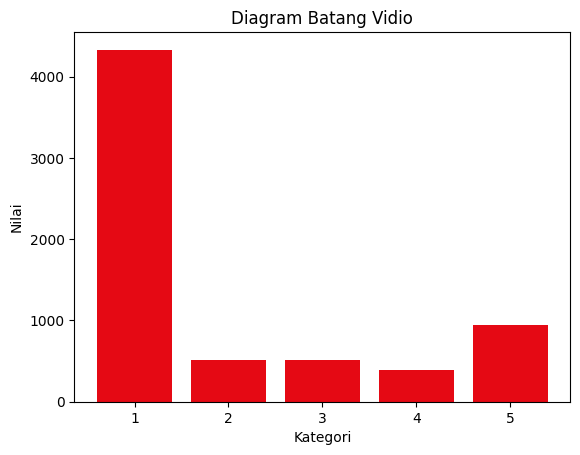

In [ ]:
# Diagram Batang Aplikasi
score_vidio = vidio['score'].value_counts().sort_index()

# Membuat diagram batang dengan warna Vidio
plt.bar(score_vidio.index, score_vidio.values, color="#E50914")

# Judul dan label
plt.title("Diagram Batang Vidio")
plt.xlabel("Kategori")
plt.ylabel("Nilai")

# Tampilkan grafik
plt.show()

In [ ]:
# Rata-rata Rating Per Tahun
waktu_vidio = vidio['score'].groupby(vidio['at'].dt.year).mean()
waktu_vidio

at
2015    3.057143
2016    3.622881
2017    3.225352
2018    2.614815
2019    2.880282
2020    2.483871
2021    2.316502
2022    1.449110
2023    1.996435
2024    1.806754
2025    1.770089
Name: score, dtype: float64

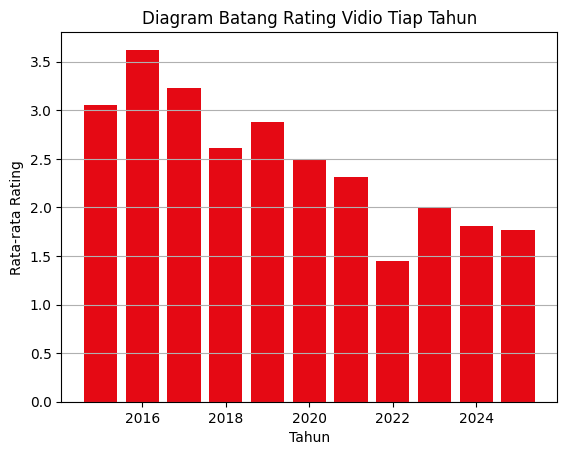

In [ ]:
# Visualisasi Rating apps setiap tahun
score_vidio_1 = vidio['score'].groupby(vidio['at'].dt.year).mean()

# Membuat diagram batang
plt.bar(score_vidio_1.index, score_vidio_1.values, color="#E50914")

# Judul dan label
plt.title("Diagram Batang Rating Vidio Tiap Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Rating")

# Tampilkan grid
plt.grid(axis='y')
plt.show()


## Analisis Rating 1 dan 5 dari Aplikasi Vidio

In [ ]:
vidio1 = vidio[vidio["score"] == 1].copy()
vidio5 = vidio[vidio["score"] == 5].copy()

### Rating 1 Vidio

In [ ]:
clean = []
kosong = []
for j, i in enumerate(vidio1['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

vidio1['clean content'] = clean
kosong

[33,
 127,
 132,
 288,
 485,
 518,
 519,
 565,
 569,
 817,
 920,
 1053,
 1102,
 1299,
 1340,
 1462,
 1723,
 1777,
 2120,
 2193,
 2229,
 2355,
 2604,
 2666,
 2771,
 2865,
 2927,
 2985,
 3273,
 3334,
 3335,
 3471,
 3639,
 3742,
 3834,
 4094,
 4140,
 4205,
 4256]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']   #list stop words bisa ditambahkan sendiri
stopwords_indo.extend(tambahan)

konten_clean_vidio1 = ""

for index, row in vidio1.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_vidio1 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_vidio1

'iklan bayar monetisasi tingkat dewa low quality isi tvi iklan mesti bayar kadena puter perangkat mobile serius tbtb paket habis izin dana potong otomatis subcribe byon combat ii auto bayar pakej email refund paket internet harga lumayan axis dapet bonus vidio platinum meng aktif bonus kuota bonus abis alias pakai tangung sikap profesional busettt platinum iklan kikir lu mahal menu web lengkap iklan habis autosubsribe pasalnak byon ja alahaiii nikmat benerfitnya transaction history history sebenernya device resek gagal verifikasi nomor handphone menu berat gol loadingrestart vidio fullscreen huawei matepad platinum iklan paket iklan subscribe byon byon knp auto pay byon nga subscribe vid khas byon nga auto pay kerna byon pulangin yaa bayar mahal seagames blokir sinetron mutu uninstal iklan recommended habis harga dinaikin ni yah nama mmmm serakah dlu siikk sinyal macet macet live akun passwordnya link verifikasi email in email gila rubah akun ngawur sctv iklan panjangternyata iklan kai

In [ ]:
clean = []
kosong = []

for j, row in vidio1.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
vidio1['clean content'] = clean

print(kosong)

[85, 379, 386, 923, 1568, 1664, 1667, 1797, 1809, 2716, 3122, 3549, 3656, 4067, 4174, 4438, 5015, 5155, 6004, 6160, 6229, 6462, 6913, 7043, 7373, 7648, 7928, 8141, 9030, 9410, 9424, 10015, 10749, 11420, 12166, 13842, 14359, 14861, 15304]


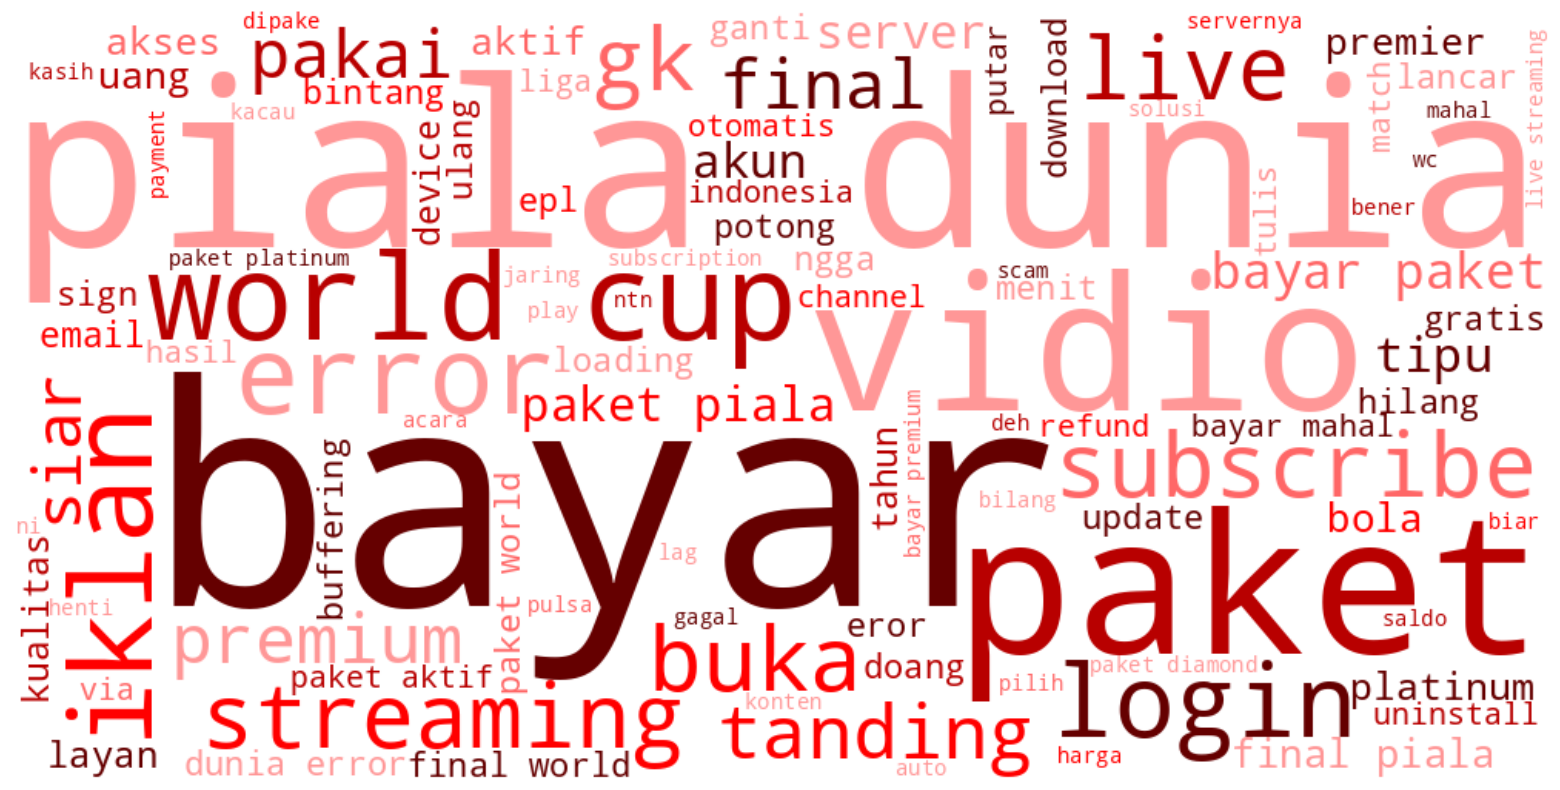

In [ ]:
# Palet warna Vidio
vidio_colors = ["#650000", "#b80000", "#ff0000", "#ff6767", "#ff9797"]

# Fungsi warna acak
def vidio_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(vidio_colors)

wordcloud_vidio1 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=vidio_color_func).generate(konten_clean_vidio1)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_vidio1, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_vidio1.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari vidio1
texts_vidio1 = vidio1['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_vidio1 = CountVectorizer(ngram_range=(3,3))
x_vidio1 = vectorizer_vidio1.fit_transform(texts_vidio1)

# mengambil daftar trigram + count
trigram_vidio1 = vectorizer_vidio1.get_feature_names_out()
trigram_counts_vidio1 = x_vidio1.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_vidio1 = pd.DataFrame({
    'Trigram': trigram_vidio1,
    'Count': trigram_counts_vidio1
})

# urutkan 50 trigram paling sering muncul
trigram_freq_vidio1 = trigram_freq_vidio1.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_vidio1)

Trigram  Count
15043        paket piala dunia    122
6776         final piala dunia    116
15306          paket world cup     76
6833           final world cup     68
15799        piala dunia error     64
22850          world cup error     27
1983         bayar piala dunia     26
2232           bayar world cup     23
1956         bayar paket piala     21
22853          world cup final     21
1968         bayar paket world     21
6639            fifa world cup     15
15801        piala dunia final     15
1928         bayar paket aktif     15
15760        piala dunia bayar     15
15796         piala dunia eror     14
15850        piala dunia login     14
15770         piala dunia buka     11
22932          world cup paket     11
22814          world cup bayar     11
18830         siar piala dunia     10
8748           in your country      9
3049   broadcaster piala dunia      9
22900          world cup login      9
1163         available in your      9
15122     paket premier league      9
13800         not available in      9
6739       final liga champion      8
15749        piala dunia akses      8
18875           siar world cup      8
1829         bayar mahal mahal      7
18693             shame on you      7
15896        piala dunia paket      7
15929       piala dunia server      7
15943      piala dunia tanding      7
14828      paket diamond tahun      7
14688        paket aktif paket      7
7106      gagal tampil halaman      7
20431      tanding piala dunia      7
19626    streaming piala dunia      7
6561            failed to load      7
6405         error piala dunia      7
1960       bayar paket premium      6
14414              out sign in      6
1958      bayar paket platinum      6
22954         world cup server      6
19905    subscribe piala dunia      6
15810           piala dunia gk      6
15570          pegang hak siar      6
15914        piala dunia qatar      6

In [ ]:
vidio1[['content']].to_excel('vidio1_content.xlsx', index=False)

### Rating 5 Vidio

In [ ]:
clean = []
kosong = []
for j, i in enumerate(vidio5['content']):
    if preprocessing(i,stopwords_indo) == []:
      kosong.append(j)
    clean_text = " ".join(preprocessing(i,stopwords_indo))
    clean.append(clean_text)

vidio5['clean content'] = clean
kosong

[32,
 46,
 69,
 72,
 111,
 112,
 119,
 122,
 127,
 152,
 167,
 187,
 191,
 193,
 195,
 224,
 226,
 295,
 301,
 302,
 308,
 328,
 331,
 337,
 340,
 343,
 367,
 377,
 387,
 405,
 406,
 425,
 453,
 482,
 507,
 509,
 515,
 532,
 551,
 553,
 555,
 565,
 580,
 601,
 628,
 633,
 635,
 647,
 667,
 672,
 675,
 687,
 688,
 699,
 709,
 733,
 736,
 768,
 779,
 788,
 828,
 842,
 844,
 857,
 939]

In [ ]:
tambahan = ['https', "http",'tco', 't', 'co', 'yg', 'gak', 'ga','nih','ko','gw','pa','hp','tp','na','sih','bgt','ep','sy','ad','tu','lang']
stopwords_indo.extend(tambahan)

konten_clean_vidio5 = ""

for index, row in vidio5.iterrows():
    review_text = row['content']
    review_lang = row['lang']

    if review_lang == 'en':
        current_stopwords = stopwords_eng
    else:
        current_stopwords = stopwords_indo

    konten_clean_vidio5 += " ".join(preprocessing(review_text, current_stopwords)) + " "

konten_clean_vidio5

'visual gambar terang cerah top streaming indo moga baca min plis lanjutin azizah cinta makasih mimin bola kasih iklan pinggir reaktivasi desember alami eror bayar saldo potong paket teraktivasi paket ultimate mobile hemat vidio konsisten olahraga series kualitas mantapp hny harga paket hmmm mudah donlot tnp buferring jg mantap adakan diskon bintang customer service fast response cooperative handle complain timbang vidio section komunikasi team cs report by email feedback customer lari review bagussss ok update saran sepakbola ketimbang tanding pay match liga inggris cuman tim favorit sisa tanding fa cup piala liga inggris sister gugur kyknya mubazir rp tanding pikir murah dlm liga champion fa cup piala liga dsb world cup final out login bayar paket ultima bln anggap paket update warna merah tulis vidio liga inggris ok premier league laliga dll paket ultimate golong worth it negeri ginian juta tahun wkwkk barat ama series anime lengkap kalah series seruuu keren gambar kualitas akses mu

In [ ]:
clean = []
kosong = []

for j, row in vidio5.iterrows():
    review_text = str(row['content'])       # pastikan string
    review_lang = row['lang']

    # pilih stopwords sesuai bahasa
    if review_lang == 'id':
        current_stopwords = stopwords_indo
    else:
        current_stopwords = stopwords_eng  # atau [] jika tidak punya stopwords Inggris

    # lakukan preprocessing
    preprocessed_tokens = preprocessing(review_text, current_stopwords)

    # cek kalau hasil preprocessing kosong
    if not preprocessed_tokens:
        kosong.append(j)

    clean_text = " ".join(preprocessed_tokens)
    clean.append(clean_text)

# masukkan ke dataframe
vidio5['clean content'] = clean

print(kosong)

[691, 1005, 1206, 1300, 2295, 2342, 2412, 2458, 2511, 2811, 3158, 5001, 5182, 5226, 5244, 5725, 6057, 8608, 8694, 8721, 8883, 9296, 9374, 9517, 9537, 9569, 9790, 9933, 10106, 10318, 10325, 10697, 11098, 11495, 11734, 11741, 11796, 12040, 12301, 12348, 12369, 12438, 12649, 12977, 13395, 13451, 13488, 13676, 13899, 13939, 13966, 14096, 14100, 14252, 14315, 14578, 14624, 15081, 15200, 15374, 15768, 15878, 15900, 15961, 16374]


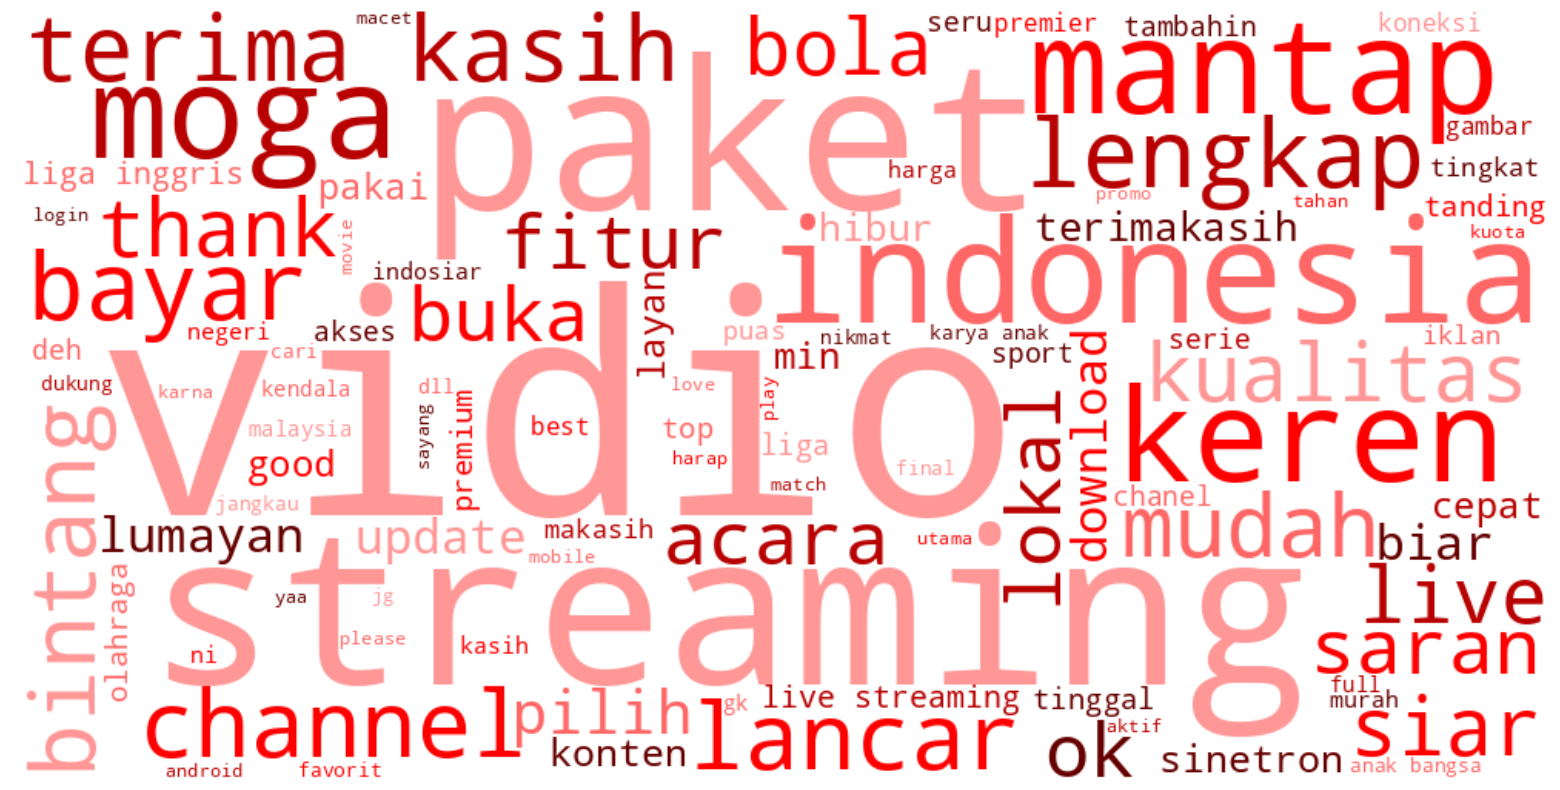

In [ ]:
# Palet warna Vidio
vidio_colors = ["#650000", "#b80000", "#ff0000", "#ff6767", "#ff9797"]
wordcloud_vidio5 =WordCloud(max_font_size=200, max_words=100, background_color="white",
                     width=1000, height=500, color_func=vidio_color_func).generate(konten_clean_vidio5)          #atur maksimum kata, background, dan ukurannya
plt.figure(figsize= (20,10))
plt.imshow(wordcloud_vidio5, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_vidio5.png")
plt.show()

In [ ]:
# ambil semua review yang sudah dibersihkan dari vidio5
texts_vidio5 = vidio5['clean content'].astype(str).tolist()

# trigram (3 kata)
vectorizer_vidio5 = CountVectorizer(ngram_range=(3,3))
x_vidio5 = vectorizer_vidio5.fit_transform(texts_vidio5)

# mengambil daftar trigram + count
trigram_vidio5 = vectorizer_vidio5.get_feature_names_out()
trigram_counts_vidio5 = x_vidio5.sum(axis=0).A1   # ubah ke array 1D

# membuat dataframe frekuensi
trigram_freq_vidio5 = pd.DataFrame({
    'Trigram': trigram_vidio5,
    'Count': trigram_counts_vidio5
})

# urutkan 50 trigram paling sering muncul
trigram_freq_vidio5 = trigram_freq_vidio5.sort_values(by='Count', ascending=False).head(50)

display(trigram_freq_vidio5)

Trigram  Count
1241           karya anak bangsa     10
2936          terima kasih vidio      8
1802             mermaid in love      3
2197             paket world cup      3
547               cup piala liga      2
1583         liga liga champions      2
3175              vidio hak siar      2
296         bintang terima kasih      2
745                 fa cup piala      2
2935            terima kasih tim      2
1270             kasih tim vidio      2
1569      liga indonesia channel      2
2245           piala dunia paket      2
1848         moga live streaming      2
2121         oops something went      2
2242          piala dunia lancar      2
1801        merespon keluh cepat      2
660          download cok muslim      2
2431        respon cepat kendala      2
1283                  keep it up      2
2500        saran tambahin fitur      2
1063  indonesia channel indosiar      2
2810     subtitle bahasa inggris      2
2182        paket premier league      2
2475          saldo potong paket      2
3155             vidio asi games      2
1035         iklan pilih channel      2
682            dukung karya anak      2
2698        something went wrong      2
2772       streaming piala dunia      2
2955               thank you for      2
3191        vidio live streaming      2
1354           klub bola favorit      2
2206         partner resmi acara      1
2207           pasar segar garap      1
2216              pay match liga      1
2215         patut beriw bintang      1
2214    patch ulang misstypetypo      1
2208       pasar segmen ambisius      1
2213             patah pokok sip      1
2212        patah koneksi stabil      1
2211        password tombol back      1
2210      paspasan tahan inovasi      1
2209              pasar ui vidio      1
2205             part doang part      1
2184         paket premium tahun      1
2185         paket premiun bayar      1
2186           paket pusing baca      1
2187          paket rewind karna      1
2188          paket smga kembang      1

In [ ]:
vidio5[['content']].to_excel('vidio5_content.xlsx', index=False)